In [1]:
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
from collections import defaultdict
from scipy import spatial
from IPython.display import HTML, display
import tabulate
import json
import pickle
import re
import nltk

# Dataset Prep

In [2]:
df = pd.read_excel("InputTestSet-Reviews48_Ann.xlsx")

In [3]:
df.head()

,UID,PID,Dec,Sent,MComp,Cat,SubCat
0,0,2019_SJf_XhCqKm,Reject,The authors propose to use k-DPP to select a s...,0,NaN,NaN
1,1,2019_SJf_XhCqKm,Reject,"This paper covers the related work nicely, wit...",0,NaN,NaN
2,2,2019_SJf_XhCqKm,Reject,The rest of the paper are also clearly written.,0,NaN,NaN
3,3,2019_SJf_XhCqKm,Reject,"However, I have some concerns about the propos...",0,NaN,NaN
4,4,2019_SJf_XhCqKm,Reject,"- It is not clear how to define the kernel, th...",0,NaN,NaN


In [4]:
df.shape

(1505, 7)

In [5]:
gt_dict = {}

for i in range(0, df.shape[0]):
    pid = df.loc[i]["PID"]
    if not pid in gt_dict:
        gt_dict[pid] = {"dec": df.loc[i]["Dec"], "mcomp": set(), "not_mcomp": set()}
    if df.loc[i]["MComp"] == 1:
        gt_dict[pid]["mcomp"].add(df.loc[i]["UID"])
    else:
        gt_dict[pid]["not_mcomp"].add(df.loc[i]["UID"])

In [6]:
stats_dict = {"Accept": [0, 0], "Reject": [0, 0]}

for k, v in gt_dict.items():
    #print(len(v["mcomp"]), len(v["not_mcomp"]), v["dec"])
    stats_dict[v["dec"]][0] += len(v["mcomp"])
    stats_dict[v["dec"]][1] += len(v["not_mcomp"])
    
print(stats_dict)

{'Accept': [48, 644], 'Reject': [69, 744]}


In [7]:
test_set = list(gt_dict.keys())
print("TestSet length: %d\n"%len(test_set), test_set)

TestSet length: 32
 ['2019_SJf_XhCqKm', '2017_Bk0MRI5lg', '2020_SyevYxHtDB', '2018_rJBiunlAW', '2020_rkltE0VKwH', '2018_Hki-ZlbA-', '2019_BJx0sjC5FX', '2020_r1e_FpNFDr', '2020_B1lsXREYvr', '2018_SkZxCk-0Z', '2019_rJzoujRct7', '2018_HkfXMz-Ab', '2017_BJ9fZNqle', '2019_SyxZJn05YX', '2017_B1ckMDqlg', '2017_HJ0NvFzxl', '2017_S1_pAu9xl', '2018_SyYYPdg0-', '2017_BJAA4wKxg', '2019_HyVxPsC9tm', '2019_HylTBhA5tQ', '2019_B1l08oAct7', '2018_H135uzZ0-', '2017_H1oyRlYgg', '2017_r1y1aawlg', '2020_r1eX1yrKwB', '2020_Byg79h4tvB', '2019_H1lFZnR5YX', '2020_BkeWw6VFwr', '2018_HyHmGyZCZ', '2018_HyUNwulC-', '2020_HkgsPhNYPS']


In [8]:
for k in test_set:
    print('{:20}{}'.format(k, gt_dict[k]["mcomp"]))

2019_SJf_XhCqKm     {39, 17, 20, 27, 28, 30}
2017_Bk0MRI5lg      {48, 57}
2020_SyevYxHtDB     {76, 87}
2018_rJBiunlAW      {108, 110, 112, 113, 124, 126}
2020_rkltE0VKwH     {160, 155, 184, 159}
2018_Hki-ZlbA-      {267, 235, 236, 271}
2019_BJx0sjC5FX     {292, 287}
2020_r1e_FpNFDr     {312, 322, 315, 308}
2020_B1lsXREYvr     {376, 401}
2018_SkZxCk-0Z      {449, 443, 445, 486}
2019_rJzoujRct7     {518, 519}
2018_HkfXMz-Ab      {573, 566}
2017_BJ9fZNqle      {627, 623, 615}
2019_SyxZJn05YX     {672, 673, 657, 669, 671}
2017_B1ckMDqlg      {714, 707}
2017_HJ0NvFzxl      {739}
2017_S1_pAu9xl      {792, 809, 810, 806}
2018_SyYYPdg0-      {834, 867, 868, 869, 870, 872, 873, 844, 830}
2017_BJAA4wKxg      {884}
2019_HyVxPsC9tm     {931, 933, 905, 909, 912, 913, 919, 926}
2019_HylTBhA5tQ     {972, 950}
2019_B1l08oAct7     {994, 996, 1064, 1004, 1007, 1044, 1047, 1048, 1055}
2018_H135uzZ0-      {1072, 1079}
2017_H1oyRlYgg      set()
2017_r1y1aawlg      {1125, 1162, 1100, 1102, 1168}
2020_r1eX1y

In [9]:
sents_for_test = defaultdict(list)

for i in range(0, df.shape[0]):
    pid = df.loc[i]["PID"]
    sents_for_test[pid].append((df.loc[i]["UID"], df.loc[i]["Sent"]))

## Load entities

In [10]:
with open("entities_dict_smaller", "r") as f:
    entity_dict = json.load(f)

In [11]:
set(entity_dict.values())

{'Material', 'Method', 'Metric', 'Task'}

In [12]:
list(entity_dict.items())[0:20]

[('convolutional neural networks', 'Method'),
 ('convnets', 'Method'),
 ('recognition', 'Task'),
 ('visual recognition tasks', 'Task'),
 ('age estimation', 'Task'),
 ('head pose estimation', 'Task'),
 ('multi - label classification', 'Task'),
 ('semantic segmentation', 'Task'),
 ('classification', 'Task'),
 ('deep convnets', 'Method'),
 ('dldl', 'Method'),
 ('feature learning', 'Task'),
 ('deep learning', 'Method'),
 ('image classification', 'Task'),
 ('deep learning methods', 'Method'),
 ('image classification tasks', 'Task'),
 ('human pose estimation', 'Task'),
 ('convnet', 'Method'),
 ('recognition tasks', 'Task'),
 ('ensemble', 'Method')]

In [13]:
entity_key_map = {}
for i in entity_dict:
    s = re.sub('[^0-9a-zA-Z,:;.?!\- ]+', '', i)
    while s.find("  ") > -1:
        s = s.replace("  ", " ")
    if len(s) > 2:
        cl = re.sub('[^0-9a-zA-Z ]+', '', i)
        while cl.find("  ") > -1:
            cl = cl.replace("  ", " ")
        entity_key_map[cl.strip()] = i
print(len(entity_key_map))

1784


In [14]:
coun = 0
for i in entity_dict:
    if len(i) < 5:
        coun +=1
#         print(i)
print(coun)

212


In [15]:
list(entity_key_map.items())[0:5]

[('convolutional neural networks', 'convolutional neural networks'),
 ('convnets', 'convnets'),
 ('recognition', 'recognition'),
 ('visual recognition tasks', 'visual recognition tasks'),
 ('age estimation', 'age estimation')]

In [16]:
from collections import Counter
c = Counter(entity_dict.values())
c

Counter({'Method': 1191, 'Task': 289, 'Metric': 158, 'Material': 165})

In [17]:
# dir(c)
reverse_map = defaultdict(list)

for k, v in entity_dict.items():
    reverse_map[v].append(k)

In [18]:
# for i in reverse_map["Task"]:
#     print(i)

In [19]:
"MNIST" in entity_key_map, "mnist" in entity_key_map

(False, True)

## A. RoBERTa trained on SciLit

In [20]:
import spacy
import torch

In [21]:
!pip3.7 list | grep -E 'transformers|tokenizers'

spacy-transformers            0.6.2
tokenizers                    0.7.0
transformers                  2.9.0


In [22]:
from transformers import AutoTokenizer, AutoModel

In [50]:
tokenizer = AutoTokenizer.from_pretrained("./trained_lm/MaskedRoBERTa/")
model = AutoModel.from_pretrained("./trained_lm/MaskedRoBERTa/")

In [51]:
import transformers
print(transformers.__version__)

2.9.0


In [52]:
def embed_text_using_roberta(text):
    input_ids = torch.tensor(tokenizer.encode(text)).unsqueeze(0)  # Batch size 1
    outputs = model(input_ids)
    last_hidden_states = outputs[0]  # The last hidden-state is the first element of the output tuple
    return last_hidden_states

In [53]:
def mask_entities(sentence, replace_with_dataset=True):
    cleaned_sent = re.sub('[^0-9a-zA-Z,:;.?!\- ]+', ' ', sentence)
    while cleaned_sent.find("  ") > -1:
        cleaned_sent = cleaned_sent.replace("  ", " ")
    
    entity_key_map_keys = list(entity_key_map.keys()) # As we will be dunamically adding entries to this dict an dthat will throw an error.
    entities_found = []
    for i in entity_key_map_keys:
        if cleaned_sent.find(" " + i + " ") > -1:
            entities_found.append(i)
        elif cleaned_sent.lower().find(" " + i + " ") > -1:
            found_idx = cleaned_sent.lower().find(" " + i + " ")
            entity_dict[cleaned_sent[found_idx:found_idx+len(" " + i + " ")]] = entity_dict[i]
            entity_key_map[cleaned_sent[found_idx:found_idx+len(" " + i + " ")]] = entity_key_map[i]
    
    entities_found.sort(key=lambda s: len(s))
    len_sorted_entities = entities_found.copy()
    
    subset_entities = []
    # Remove subset entities (eg: Among cnn and 3-layer-cnn, prefer the latter)
    for fe in len_sorted_entities:
        for other_ent in len_sorted_entities:
            if fe != other_ent and other_ent.find(fe) > -1:
                subset_entities.append(fe)
                break
    for se in subset_entities:
        len_sorted_entities.remove(se)
    for maxents in len_sorted_entities:
        mask_name = " " + entity_dict[entity_key_map[i]].lower() + " "
        if replace_with_dataset:
            if mask_name == " material ":
                mask_name = " dataset "
        cleaned_sent = cleaned_sent.replace(" " + maxents + " ", mask_name)
    words_cleaned = nltk.word_tokenize(cleaned_sent)
    dups_removed = [v for i, v in enumerate(words_cleaned) if i == 0 or v != words_cleaned[i-1]]
    new_dup_removed_sent = " ".join(dups_removed)
    return new_dup_removed_sent.strip()

#     #print(cleaned_sent)
#     for i in entity_key_map:
#         if cleaned_sent.find(" " + i + " ") > -1:
#             #print("Substituting ent: {} with mask: {}".format(i, entity_dict[entity_key_map[i]].lower()))
#             cleaned_sent = cleaned_sent.replace(i, entity_dict[entity_key_map[i]].lower())
#     return cleaned_sent

In [54]:
mask_entities("In the BO-PET test*, the best method is to take\ risks. This leads to substantial improvement in results.")

'In the BO-PET test , the best method is to take risks . This leads to substantial improvement in results .'

In [55]:
nltk.word_tokenize("this is a test")

['this', 'is', 'a', 'test']

In [56]:
nlp = spacy.load('en_core_web_sm')
sp_toks = ["result", "method", "task", "dataset", "metric", "baseline", "fair", "unfair"]

In [57]:
def extract_chunks_using_spacy_dp(conssentence, replace_with_dataset=True):
    
    conssentence = mask_entities(conssentence, replace_with_dataset)
#     print(conssentence)
    doc = nlp(conssentence)
    verb_subtree = []

    for s in doc.sents:
#         find_special_tokens = {"compar": [], "result": [], "method": [], "technique": [], "task": [], "dataset": [], "material": [], "metric": []}
        find_special_tokens = {"compar": [], "result": [], "method": [], "baseline": [], "task": [], 
                               "dataset": [],  "metric": [], "unfair": [], "fair": []}

        for tok in s:

            if tok.text.lower().startswith("compar"):
                find_special_tokens["compar"].append(tok)
            else:
                for k in sp_toks:
                    if tok.text.lower().startswith(k):
                        find_special_tokens[k].append(tok)
                        break

        verb_tokens = []
        if find_special_tokens["compar"]:
            for t in find_special_tokens["compar"]:
#                     verb_subtree.append(t.subtree)
                if t == s.root:
                    simplified_sent = ""
                    for chh in t.lefts:
                        simplified_sent = simplified_sent + " " + chh.text
                    simplified_sent = simplified_sent + " " + t.text
                    for chh in t.rights:
                        simplified_sent = simplified_sent + " " + chh.text
#                         print("SIMP: ", simplified_sent)
                    verb_subtree.append(simplified_sent)
                else:
                    verb_subtree.append(t.subtree)
        else:
            for k in sp_toks:
                for i in find_special_tokens[k]:
                    local_vt = []
                    for j in i.ancestors:
                        if j.pos_ == "NOUN":
                            local_vt.append(j)
                    if not local_vt:
                        for j in i.ancestors:
                            if j.pos_ == "VERB":
                                local_vt.append(j)
                    verb_tokens = verb_tokens + local_vt


            for i in verb_tokens:
                verb_subtree.append(i.subtree)

    eecc = []
    for i in verb_subtree:
        if type(i) == str:
            eecc.append(i)
        else:
            local_chunk = ""
            for lcaltok in i:
                local_chunk = local_chunk + " " + lcaltok.text
            eecc.append(local_chunk)
#     if not eecc:
#         print(conssentence)
    return list(set(eecc))


In [58]:
extract_chunks_using_spacy_dp("It would be interesting to explore the practicability of the method on more large-scale experiments on image related tasks.")

[' the practicability of the method',
 ' more large - scale experiments on image related tasks']

In [59]:
extract_chunks_using_spacy_dp("The experimental validation is also not extensive since comparison to SOTA is not included.")

[' comparison to SOTA']

In [60]:
roberta_vectors = defaultdict(dict)
skip_uids = []

for pid in gt_dict:
    roberta_vectors[pid] = {}
    
    for mcs in gt_dict[pid]["mcomp"]:
        try:
            mcomp_chunks_from_sent = extract_chunks_using_spacy_dp(df.loc[mcs]["Sent"])
            if mcomp_chunks_from_sent:
                final_chunk = ". ".join(mcomp_chunks_from_sent)
            else:
                final_chunk = df.loc[mcs]["Sent"]
            
            vec = embed_text_using_roberta(final_chunk.strip()).mean(1).detach().numpy()
            roberta_vectors[pid][mcs] = vec / norm(vec)
        except Exception as ex:
            print(pid, mcs, df.loc[mcs]["Sent"])
            skip_uids.append(mcs)
    
    for mcs in gt_dict[pid]["not_mcomp"]:
        try:
            mcomp_chunks_from_sent = extract_chunks_using_spacy_dp(df.loc[mcs]["Sent"])
            if mcomp_chunks_from_sent:
                final_chunk = ". ".join(mcomp_chunks_from_sent)
            else:
                final_chunk = df.loc[mcs]["Sent"]
            
            vec = embed_text_using_roberta(final_chunk.strip()).mean(1).detach().numpy()
            roberta_vectors[pid][mcs] = vec / norm(vec)
        except Exception as ex:
            print(pid, mcs, df.loc[mcs]["Sent"])
            skip_uids.append(mcs)

2019_HyVxPsC9tm 938 2
2019_HyVxPsC9tm 940 3
2020_Byg79h4tvB 1272 [1] Conditional adversarial domain adaptation, Long et.al, in NeurIPS 2018
[2] Towards Accurate Model Selection in Deep Unsupervised Domain Adaptation, You et.al, in ICML 2019
2018_HyHmGyZCZ 1425 2


In [61]:
mcomp_sentences = {}
not_mcomp_sentences = {}

for pid in gt_dict:
    for mcs in gt_dict[pid]["mcomp"]:
        if not mcs in skip_uids:
            mcomp_sentences[mcs] = pid
    for mcs in gt_dict[pid]["not_mcomp"]:
        if not mcs in skip_uids:
            not_mcomp_sentences[mcs] = pid
print(len(mcomp_sentences), len(not_mcomp_sentences))

117 1384


In [62]:
sim_with_mcomp = defaultdict(dict)
sim_with_not_mcomp = defaultdict(dict)
sim_with_notmcomp_paper_sents = defaultdict(dict)

mean_at_k = ["1", "3", "5", "7", "10", "20", "30", "50", "100", "500", "1000", "1380"]

for sid in mcomp_sentences:
    
    # 1. With other mcomp sentences
    temp_list = []    
    for osid in mcomp_sentences:
        if osid != sid:
            temp_list.append(np.inner(roberta_vectors[mcomp_sentences[osid]][osid], roberta_vectors[mcomp_sentences[sid]][sid])[0][0])
    
    sorted_temp_list = sorted(temp_list, reverse=True)
    sim_with_mcomp[sid]["mean"] = np.mean(sorted_temp_list)
    for vv in mean_at_k:
        sim_with_mcomp[sid]["mean_{}".format(vv)] = np.mean(sorted_temp_list[0:int(vv)])

    
    # 2. With other not_mcomp_sentences
    temp_list = []
    for osid in not_mcomp_sentences:
        temp_list.append(np.inner(roberta_vectors[not_mcomp_sentences[osid]][osid], roberta_vectors[mcomp_sentences[sid]][sid])[0][0])
    
    sorted_temp_list = sorted(temp_list, reverse=True)
    sim_with_not_mcomp[sid]["mean"] = np.mean(sorted_temp_list)
    for vv in mean_at_k:
        sim_with_not_mcomp[sid]["mean_{}".format(vv)] = np.mean(sorted_temp_list[0:int(vv)])

    
    # 3. With not_mcomp_sentences of the same paper
    temp_list = []    
    for osid in not_mcomp_sentences:
        if not_mcomp_sentences[osid] == mcomp_sentences[sid]:
            temp_list.append(np.inner(roberta_vectors[not_mcomp_sentences[osid]][osid], roberta_vectors[mcomp_sentences[sid]][sid])[0][0])
    
    sorted_temp_list = sorted(temp_list, reverse=True)
    sim_with_notmcomp_paper_sents[sid]["mean"] = np.mean(sorted_temp_list)
    for vv in mean_at_k:
        sim_with_notmcomp_paper_sents[sid]["mean_{}".format(vv)] = np.mean(sorted_temp_list[0:int(vv)])
    

In [63]:
# mean_sim_plot
diff12 = {"all": []}
for vv in mean_at_k:
    diff12[str(vv)] = []

diff13 = {"all": []}
for vv in mean_at_k:
    diff13[str(vv)] = []

for sid in sim_with_mcomp:
    diff12["all"].append(sim_with_mcomp[sid]["mean"] - sim_with_not_mcomp[sid]["mean"])
    diff13["all"].append(sim_with_mcomp[sid]["mean"] - sim_with_notmcomp_paper_sents[sid]["mean"])
    
    for vv in mean_at_k:
        diff12[str(vv)].append(sim_with_mcomp[sid]["mean_{}".format(vv)] - sim_with_not_mcomp[sid]["mean_{}".format(vv)])
        diff13[str(vv)].append(sim_with_mcomp[sid]["mean_{}".format(vv)] - sim_with_notmcomp_paper_sents[sid]["mean_{}".format(vv)])


## Masked RoBERTa

In [64]:
# With dataset as mask
res_table = [[""] + mean_at_k, [""]]

for val in mean_at_k:
    v1 = round(sum(i > 0 for i in diff12[val])/len(diff12[val]), 2)
    res_table[1].append(v1)

display(HTML(tabulate.tabulate(res_table, tablefmt='html')))

,1,3,5,7,10,20,30,50,100,500,1000,1380
,0.48,0.44,0.39,0.38,0.34,0.24,0.2,0.14,0.01,0.3,0.62,0.88


In [65]:
# With dataset as mask
res_table = [[""] + mean_at_k, [""]]

for val in mean_at_k:
    v1 = round(sum(i > 0 for i in diff13[val])/len(diff13[val]), 2)
    res_table[1].append(v1)

display(HTML(tabulate.tabulate(res_table, tablefmt='html')))

,1,3,5,7,10,20,30,50,100,500,1000,1380
,0.8,0.79,0.84,0.85,0.86,0.9,0.91,0.96,0.85,0.74,0.74,0.74


In [67]:
# With dataset as mask
res_table = [[""] + mean_at_k, [""]]

for val in mean_at_k:
    v1 = round(sum(i > 0 for i in diff12[val])/len(diff12[val]), 2)
    res_table[1].append(v1)

display(HTML(tabulate.tabulate(res_table, tablefmt='html')))
# With dataset as mask
res_table = [[""] + mean_at_k, [""]]

for val in mean_at_k:
    v1 = round(sum(i > 0 for i in diff13[val])/len(diff13[val]), 2)
    res_table[1].append(v1)

display(HTML(tabulate.tabulate(res_table, tablefmt='html')))

,1,3,5,7,10,20,30,50,100,500,1000,1380
,0.48,0.44,0.39,0.38,0.34,0.24,0.2,0.14,0.01,0.3,0.62,0.88


,1,3,5,7,10,20,30,50,100,500,1000,1380
,0.8,0.79,0.84,0.85,0.86,0.9,0.91,0.96,0.85,0.74,0.74,0.74


In [38]:
# With dataset as mask
res_table = [[""] + mean_at_k, [""]]

for val in mean_at_k:
    v1 = round(sum(i > 0 for i in diff12[val])/len(diff12[val]), 2)
    res_table[1].append(v1)

display(HTML(tabulate.tabulate(res_table, tablefmt='html')))

,1,3,5,7,10,20,30,50,100,500,1000,1380
,0.48,0.4,0.39,0.33,0.3,0.21,0.19,0.1,0,0.18,0.51,0.84


In [39]:
# With dataset as mask
res_table = [[""] + mean_at_k, [""]]

for val in mean_at_k:
    v1 = round(sum(i > 0 for i in diff13[val])/len(diff13[val]), 2)
    res_table[1].append(v1)

display(HTML(tabulate.tabulate(res_table, tablefmt='html')))

,1,3,5,7,10,20,30,50,100,500,1000,1380
,0.76,0.84,0.85,0.85,0.87,0.92,0.95,0.96,0.8,0.68,0.68,0.68


# Reinstalling transformers?? and smaller entity set

In [40]:
# With dataset as mask
res_table = [[""] + mean_at_k, [""]]

for val in mean_at_k:
    v1 = round(sum(i > 0 for i in diff12[val])/len(diff12[val]), 2)
    res_table[1].append(v1)

display(HTML(tabulate.tabulate(res_table, tablefmt='html')))

,1,3,5,7,10,20,30,50,100,500,1000,1380
,0.49,0.42,0.38,0.33,0.3,0.21,0.19,0.1,0,0.19,0.52,0.83


In [41]:
# With dataset as mask
res_table = [[""] + mean_at_k, [""]]

for val in mean_at_k:
    v1 = round(sum(i > 0 for i in diff13[val])/len(diff13[val]), 2)
    res_table[1].append(v1)

display(HTML(tabulate.tabulate(res_table, tablefmt='html')))

,1,3,5,7,10,20,30,50,100,500,1000,1380
,0.76,0.84,0.85,0.85,0.86,0.92,0.95,0.97,0.79,0.68,0.68,0.68


# ==========================================================

# 2. BERT model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("./trained_lm//")
model = AutoModel.from_pretrained("./trained_lm//")

# Till here only.

# ==========================================================

# 2. Chunks ext

In [42]:
from stanfordcorenlp import StanfordCoreNLP
from nltk.tree import Tree

In [43]:
corenlp = StanfordCoreNLP("/home/shruti/Documents/DataNLP/stanford-corenlp-4.1.0/")

In [44]:
def get_chunks(sent):
    parse_str = corenlp.parse(sent)
    nltk_tree = Tree.fromstring(parse_str)
    
#     print(nltk_tree)
    
    subtrees_list = list(nltk_tree.subtrees())
    subtrees_tpos = nltk_tree.treepositions()
    for i in range(0, len(nltk_tree.leaves())):
        tp_leaf = nltk_tree.leaf_treeposition(i)
        subtrees_tpos.remove(tp_leaf)
    
    dict_len_st = {}
    depth_of_subtree = []
    for _, i in enumerate(subtrees_list):
        depth_of_subtree.append((i, len(subtrees_tpos[_])))
        dict_len_st[str(i)] = len(subtrees_tpos[_])
    
    cdepths = []
    for d in depth_of_subtree:
        cdepths.append(d[1])
    depth_counter = Counter(cdepths)
    sorted_depths = sorted(list(depth_counter.keys()))
    print(sorted(depth_counter.items(), key=lambda x: x[0]))
    
    depth_to_split = None
    print(sorted_depths) 
    for sd in sorted_depths:
        if depth_counter[sd] == 3:
            depth_to_split = 3
        elif depth_counter[sd] > 3:
            depth_to_split = sd
            break
    if depth_to_split == None or depth_to_split == 4:
        print("Depth to split: {}".format(depth_to_split))
        
    print("depth: ", depth_to_split)
    
    subtree_chunks = []
    for i in depth_of_subtree:
        if i[1] == depth_to_split:
            subtree_chunks.append(i)
    
    final_chunks_sent = []
    
#     for tt in subtree_chunks:
#         print(tt)
    
    for stchunk in subtree_chunks:
        print(len(stchunk[0].leaves()), stchunk[0].leaves())
#         print(stchunk)
        if len(stchunk[0].leaves()) > 5:
            subsubtrees = list(stchunk[0].subtrees())
            fnlsubsub = []
            for sss in subsubtrees:
                if str(sss) in dict_len_st and dict_len_st[str(sss)] == depth_to_split+1:
                    fnlsubsub.append(sss)
            for subchunk in fnlsubsub:
                final_chunks_sent.append(" ".join(subchunk.leaves()))
        else:
            final_chunks_sent.append(" ".join(stchunk[0].leaves()))
#         final_chunks_sent.append(" ".join(stchunk[0].leaves()))
    
    return final_chunks_sent

In [45]:
s = "Second, their study only applies to a small number like 3-6 hyperparameters with a small k=20) The real challenge lies in scaling up to many hyperparameters or even k-DPP sampling for larger k. Third, the authors do not compare against some relevant, recent work, e.g., Springenberg et al (http://aad.informatik.uni-freiburg.de/papers/16-NIPS-BOHamiANN.pdf) and Snoek et al (https://arxiv.org/pdf/1502.05700.pdf) that is essential for this kind of empirical study."

In [46]:
print(s)
get_chunks(s)

Second, their study only applies to a small number like 3-6 hyperparameters with a small k=20) The real challenge lies in scaling up to many hyperparameters or even k-DPP sampling for larger k. Third, the authors do not compare against some relevant, recent work, e.g., Springenberg et al (http://aad.informatik.uni-freiburg.de/papers/16-NIPS-BOHamiANN.pdf) and Snoek et al (https://arxiv.org/pdf/1502.05700.pdf) that is essential for this kind of empirical study.
[(0, 1), (1, 1), (2, 10), (3, 10), (4, 21), (5, 16), (6, 12), (7, 24), (8, 15), (9, 8), (10, 6), (11, 9), (12, 6), (13, 4)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
depth:  2
1 ['Second']
1 [',']
19 ['their', 'study', 'only', 'applies', 'to', 'a', 'small', 'number', 'like', '3', '-', '6', 'hyperparameters', 'with', 'a', 'small', 'k', '=', '20']
1 ['-RRB-']
20 ['The', 'real', 'challenge', 'lies', 'in', 'scaling', 'up', 'to', 'many', 'hyperparameters', 'or', 'even', 'k', '-', 'DPP', 'sampling', 'for', 'larger', 'k.', 'Third']

['Second',
 ',',
 'their study',
 'only',
 'applies to a small number like 3 - 6 hyperparameters with a small k = 20',
 '-RRB-',
 'The real challenge',
 'lies in scaling up to many hyperparameters or even k - DPP sampling for larger k. Third',
 ',',
 'the authors',
 'do not compare against some relevant , recent work , e.g.',
 ',',
 'Springenberg et al',
 '-LRB- http://aad.informatik.uni-freiburg.de/papers/16-NIPS-BOHamiANN.pdf -RRB- and Snoek et al -LRB- https://arxiv.org/pdf/1502.05700.pdf -RRB- that is essential for this kind of empirical study',
 '.']

In [47]:
chunks_from_sent = {"mcomp": [], "nmcomp": []}

for pid in gt_dict:
    
    for mcs in gt_dict[pid]["mcomp"]:
        try:
            mcomp_chunks_from_sent = get_chunks(df.loc[mcs]["Sent"])
            chunks_from_sent["mcomp"].append((df.loc[mcs]["Sent"], mcomp_chunks_from_sent))
        except Exception as ex:
            print(pid, mcs)
    
    for mcs in gt_dict[pid]["not_mcomp"]:
        try:
            mcomp_chunks_from_sent = get_chunks(df.loc[mcs]["Sent"])
            chunks_from_sent["nmcomp"].append((df.loc[mcs]["Sent"], mcomp_chunks_from_sent))
        except Exception as ex:
            print(pid, mcs)

[(0, 1), (1, 1), (2, 3), (3, 3), (4, 2), (5, 2), (6, 1), (7, 2), (8, 3), (9, 4), (10, 6), (11, 7), (12, 6)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
depth:  9
2 ['the', 'practicability']
3 ['of', 'the', 'method']
1 ['on']
9 ['more', 'large', '-', 'scale', 'experiments', 'on', 'image', 'related', 'tasks']
[(0, 1), (1, 1), (2, 4), (3, 4), (4, 8), (5, 11), (6, 7), (7, 9), (8, 6), (9, 7), (10, 1)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
depth:  2
10 ['I', 'think', 'a', 'clearer', 'emphasis', 'on', 'the', 'novelty', ',', 'eg']
1 [':']
18 ['current', 'algorithm', 'with', 'mixing', 'rate', 'analyses', 'or', 'more', 'thorough', 'empirical', 'comparisons', 'will', 'make', 'the', 'paper', 'stronger', 'for', 'resubmission']
1 ['.']
[(0, 1), (1, 1), (2, 3), (3, 5), (4, 7), (5, 13), (6, 16), (7, 23), (8, 18), (9, 11), (10, 7), (11, 5), (12, 4), (13, 1)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
depth:  3
1 ['The']
1 ['authors']
20 ['propose', 'k', '-', 'DPP', 'as', 'an', 'open', 'loop', '-LRB-', 

[(0, 1), (1, 1), (2, 3), (3, 4), (4, 7), (5, 4), (6, 6), (7, 10), (8, 11), (9, 6), (10, 4), (11, 4), (12, 8), (13, 5), (14, 3), (15, 3), (16, 5)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
depth:  3
3 ['The', 'first', 'experiment']
3 ['by', 'the', 'authors']
1 ['shows']
40 ['that', 'k', '-', 'DPP', '-', 'RBF', 'gives', 'better', 'star', 'discrepancy', 'than', 'uniform', 'random', 'search', 'while', 'being', 'comparable', 'to', 'low', '-', 'discrepancy', 'Sobol', 'sequences', 'in', 'other', 'metrics', 'such', 'as', 'distance', 'from', 'the', 'center', 'or', 'an', 'arbitrary', 'corner', '-LRB-', 'Figure', '1', '-RRB-']
[(0, 1), (1, 1), (2, 5), (3, 6), (4, 11), (5, 14), (6, 10), (7, 6), (8, 9), (9, 8), (10, 3)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
depth:  2
24 ['The', 'second', 'experiment', 'shows', 'surprisingly', 'that', 'for', 'the', 'hard', 'learning', 'rate', 'range', ',', 'k', '-', 'DPP', '-', 'RBF', 'performs', 'better', 'than', 'uniform', 'random', 'search']
1 [',']

[(0, 1), (1, 1), (2, 3), (3, 6), (4, 10), (5, 8), (6, 7), (7, 10), (8, 9), (9, 4), (10, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
depth:  3
2 ['The', 'idea']
14 ['put', 'forth', 'that', 'SOI', 'map', 'networks', 'without', 'additional', 'nonlinearities', 'are', 'comparable', 'to', 'linear', 'functions']
1 ['is']
5 ['rather', 'misleading', 'as', 'they', 'are']
1 [',']
8 ['in', 'expectation', ',', 'nonlinear', 'functions', 'of', 'their', 'input']
[(0, 1), (1, 1), (2, 3), (3, 4), (4, 6), (5, 8), (6, 3), (7, 6), (8, 7), (9, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
depth:  3
10 ['Varying', 'an', 'input', 'example', 'by', 'multiplying', 'or', 'adding', 'a', 'constant']
1 ['will']
1 ['not']
10 ['be', 'linearly', 'reflected', 'in', 'the', 'expected', 'output', 'of', 'the', 'network']
[(0, 1), (1, 1), (2, 4), (3, 5), (4, 5), (5, 2), (6, 2), (7, 4), (8, 2), (9, 3), (10, 4)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
depth:  2
3 ['In', 'this', 'sense']
1 ['they']
12 ['are', 'more', 'nonlinear', 'than', 'ReLU', 'n

[(0, 1), (1, 1), (2, 4), (3, 5), (4, 5), (5, 11), (6, 7), (7, 6), (8, 7), (9, 10), (10, 6), (11, 6), (12, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
depth:  2
1 ['Concerns']
1 [':']
35 ['1', '-RRB-', 'You', 'note', 'that', 'the', 'random', 'perturbation', 'to', 'the', 'outputs', 'performs', 'poorly', 'compared', 'to', 'your', 'method', ',', 'but', 'this', 'performance', 'gap', 'seems', 'to', 'decrease', 'as', 'the', 'dataset', 'becomes', 'more', 'difficult', '-LRB-', 'ie', 'CIFAR100', '-RRB-']
1 ['.']
[(0, 1), (1, 1), (2, 4), (3, 4), (4, 10), (5, 5), (6, 4), (7, 3), (8, 2), (9, 2), (10, 2), (11, 4), (12, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
depth:  2
13 ['I', '’m', 'concerned', 'that', 'this', 'may', 'indicate', 'that', 'the', 'attackers', 'are', 'generally', 'weak']
1 ['and']
8 ['this', 'threat', 'model', 'may', 'not', 'be', 'very', 'serious']
1 ['.']
[(0, 1), (1, 1), (2, 6), (3, 5), (4, 9), (5, 7), (6, 7), (7, 12), (8, 5)]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
depth:  2
1 ['Overa

[(0, 1), (1, 1), (2, 3), (3, 4), (4, 3), (5, 6), (6, 7), (7, 8), (8, 10), (9, 2), (10, 2), (11, 2), (12, 6), (13, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
depth:  3
3 ['-', 'Slightly', 'unfortunate']
1 ['naming']
1 ['that']
24 ['does', 'not', 'account', 'for', 'autoregressive', 'CNNs', '-', 'Lack', 'of', 'comparison', 'with', 'autoregressive', 'CNN', 'baselines', ',', 'which', 'signals', 'a', 'major', 'conceptual', 'error', 'in', 'the', 'paper']
[(0, 1), (1, 1), (2, 5), (3, 8), (4, 13), (5, 7), (6, 5), (7, 3), (8, 2), (9, 4), (10, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
depth:  2
4 ['I', 'recommend', 'showing', 'exhaustively']
1 ['and']
14 ['experimentally', 'that', 'gated', 'incremental', 'pooling', 'can', 'be', 'helpful', 'for', 'autoregressive', 'CNNs', 'on', 'sequence', 'tasks']
7 ['-LRB-', 'MT', ',', 'LM', 'and', 'ASR', '-RRB-']
1 ['.']
[(0, 1), (1, 1), (2, 3), (3, 3), (4, 4), (5, 5), (6, 2), (7, 4), (8, 1)]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
Depth to split: 4
depth:  4
1 ['adju

[(0, 1), (1, 1), (2, 5), (3, 7), (4, 8), (5, 11), (6, 9), (7, 8), (8, 3), (9, 5), (10, 6), (11, 1)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
depth:  2
15 ['Since', 'it', 'is', 'already', 'extensively', 'known', 'that', 'autoregressive', 'CNNs', 'and', 'attentional', 'models', 'can', 'achieve', 'this']
1 [',']
8 ['the', '*', 'CNN', '*', 'part', 'of', 'the', 'paper']
8 ['can', 'not', 'be', 'counted', 'as', 'a', 'novel', 'contribution']
1 ['.']
[(0, 1), (1, 1), (2, 3), (3, 6), (4, 11), (5, 8), (6, 8), (7, 4), (8, 6), (9, 5), (10, 3), (11, 3), (12, 3)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
depth:  3
5 ['Pros', ':', '-', 'Fairly', 'well']
15 ['presented', '-', 'Wide', 'range', 'of', 'experiments', ',', 'despite', 'underwhelming', 'absolute', 'results', 'Cons', ':', '-', 'Quasi-RNNs']
3 ['are', 'almost', 'identical']
1 ['and']
1 ['already']
7 ['have', 'results', 'on', 'small', '-', 'scale', 'tasks']
[(0, 1), (1, 1), (2, 4), (3, 4), (4, 4), (5, 4), (6, 3), (7, 9), (8, 10), (9, 8), (10, 5),

[(0, 1), (1, 1), (2, 5), (3, 5), (4, 4), (5, 7), (6, 9), (7, 8), (8, 6), (9, 5), (10, 2), (11, 3)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
depth:  2
8 ['Once', 'the', 'trajectories', 'of', 'both', 'agents', 'are', 'found']
1 [',']
1 ['they']
17 ['can', 'be', 'distilled', 'to', 'each', 'of', 'them', 'individually', 'so', 'that', 'they', 'only', 'depend', 'on', 'the', 'local', 'observation']
1 ['.']
[(0, 1), (1, 1), (2, 5), (3, 5), (4, 4), (5, 6), (6, 8), (7, 9), (8, 2), (9, 5), (10, 7), (11, 10), (12, 8), (13, 14), (14, 7), (15, 5), (16, 2), (17, 2), (18, 2), (19, 3)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
depth:  2
7 ['Regarding', 'the', 'experiments', 'on', 'the', 'Vizdoom', 'environment']
1 [',']
1 ['it']
49 ['appears', 'that', 'the', 'traditional', 'evaluation', 'setup', '[', '3', ']', 'does', "n't", 'involve', 'providing', 'the', 'global', 'position', '-LRB-', 'x', ',', 'y', '-RRB-', 'to', 'the', 'agents', 'as', 'part', 'of', 'the', 'observations', '-

[(0, 1), (1, 1), (2, 3), (3, 5), (4, 2), (5, 4), (6, 7), (7, 10), (8, 8), (9, 6), (10, 6)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
depth:  3
1 ['The']
1 ['ability']
14 ['to', 'ask', 'other', 'agents', 'in', 'the', 'world', 'about', 'there', 'preferences', 'and', 'novelty', 'of', 'states']
1 ['appears']
12 ['to', 'be', 'a', 'strong', 'assumption', ',', 'especially', 'in', 'a', 'multi-agent', 'robotics', 'problem']
[(0, 1), (1, 1), (2, 5), (3, 4), (4, 2), (5, 4), (6, 2), (7, 2), (8, 5), (9, 7), (10, 3), (11, 4), (12, 3), (13, 2), (14, 2), (15, 1), (16, 2), (17, 2), (18, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
depth:  2
1 ['-']
23 ['While', 'the', 'authors', 'note', 'that', 'the', 'intrinsic', 'rewards', 'used', 'in', 'this', 'work', 'are', 'not', 'comprehensive', 'it', 'would', 'be', 'good', 'to', 'note', 'how', 'comprehensive']
1 ['they']
1 ['are']
1 ['.']
[(0, 1), (1, 1), (2, 4), (3, 3), (4, 4), (5, 2), (6, 2), (7, 3), (8, 3), (9, 1)]
[0, 1, 2, 3, 4, 5, 6, 7, 

[(0, 1), (1, 1), (2, 4), (3, 4), (4, 2), (5, 2), (6, 2), (7, 4), (8, 6), (9, 2), (10, 3), (11, 2), (12, 6), (13, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
depth:  2
1 ['-']
1 ['I']
18 ['am', 'not', 'sure', 'if', 'the', 'discussion', 'on', 'the', 'behaviours', 'the', 'intrinsic', 'reward', 'functions', 'result', 'in', 'are', 'very', 'surprising']
1 ['.']
[(0, 1), (1, 1), (2, 4), (3, 4), (4, 2), (5, 5), (6, 4), (7, 2), (8, 2), (9, 2), (10, 4), (11, 3)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
depth:  2
1 ['Maybe']
1 ['there']
14 ['is', 'a', 'more', 'interesting', 'behaviour', 'that', 'results', 'from', 'the', 'combination', 'of', 'two', 'intrinsic', 'rewards']
1 ['?']
[(0, 1), (1, 1), (2, 4), (3, 3), (4, 5), (5, 4), (6, 1), (7, 2), (8, 2), (9, 5), (10, 2), (11, 3), (12, 2), (13, 5), (14, 1)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
depth:  2
1 ['Summary']
1 [':']
18 ['The', 'paper', 'proposes', 'a', 'method', 'for', 'coordinating', 'the', 'exploration', 'efforts', 'of', 

[(0, 1), (1, 1), (2, 4), (3, 5), (4, 4), (5, 5), (6, 4), (7, 3)]
[0, 1, 2, 3, 4, 5, 6, 7]
depth:  2
2 ['3', '-RRB-']
8 ['Should', '\\', 'Pi', 'in', '-LRB-', '10', '-RRB-', 'also']
3 ['depend', 'on', 'i']
1 ['?']
[(0, 1), (1, 1), (2, 4), (3, 5), (4, 3), (5, 6), (6, 7), (7, 2)]
[0, 1, 2, 3, 4, 5, 6, 7]
depth:  2
6 ['Though', 'paper', 'is', 'reasonably', 'well', 'written']
1 ['I']
6 ['find', 'the', 'contributions', 'are', 'very', 'marginal']
1 ['.']
[(0, 1), (1, 1), (2, 4), (3, 5), (4, 4), (5, 4), (6, 3), (7, 6), (8, 7), (9, 6), (10, 5)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
depth:  2
19 ['If', 'authors', 'can', 'position', 'the', 'paper', 'well', 'with', 'the', 'existing', 'literature', 'and', 'bring', 'out', 'the', 'impact', 'of', 'the', 'contributions']
1 ['it']
3 ['will', 'be', 'helpful']
1 ['.']
[(0, 1), (1, 1), (2, 3), (3, 4), (4, 5), (5, 4), (6, 1)]
[0, 1, 2, 3, 4, 5, 6]
depth:  3
1 ['Tests']
3 ['on', 'another', 'dataset']
1 ['would']
3 ['have', 'been', 'welcomed']
[(0, 1), (1, 1), (2

[(0, 1), (1, 1), (2, 3), (3, 3), (4, 1), (5, 2), (6, 3), (7, 4), (8, 5), (9, 3), (10, 5), (11, 5), (12, 5), (13, 6), (14, 8), (15, 6), (16, 8), (17, 7), (18, 3)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
depth:  7
1 ['be']
18 ['more', 'useful', 'to', 'investigate', 'attacks', 'that', 'are', 'perceptually', 'insignificant', ',', 'or', 'attacks', 'that', 'operate', 'in', 'the', 'physical', 'world']
1 [',']
13 ['as', 'these', 'are', 'more', 'likely', 'to', 'be', 'a', 'concern', 'for', 'real', 'world', 'systems']
[(0, 1), (1, 1), (2, 4), (3, 3), (4, 4), (5, 3), (6, 1), (7, 4), (8, 4), (9, 7), (10, 9), (11, 8), (12, 4), (13, 5), (14, 6), (15, 8), (16, 7), (17, 9), (18, 4), (19, 3), (20, 4), (21, 3), (22, 11), (23, 9), (24, 5), (25, 7), (26, 4), (27, 7), (28, 2), (29, 2), (30, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
depth:  2
1 ['Summary']
1 [':']
76 ['The', 'paper', 'proposes', 'a', 'meth

[(0, 1), (1, 1), (2, 3), (3, 4), (4, 1), (5, 2), (6, 3), (7, 4), (8, 6), (9, 3), (10, 2), (11, 2), (12, 2), (13, 4), (14, 3)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
depth:  3
1 ['The']
1 ['authors']
1 ['propose']
18 ['to', 'employ', 'provably', 'minimal', '-', 'distance', 'examples', 'as', 'a', 'tool', 'to', 'evaluate', 'the', 'robustness', 'of', 'a', 'trained', 'network']
[(0, 1), (1, 1), (2, 3), (3, 3), (4, 2), (5, 2), (6, 2), (7, 5), (8, 5), (9, 4)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
depth:  7
1 ['a']
3 ['small', '-', 'scale']
1 ['network']
1 ['using']
4 ['the', 'MNIST', 'data', 'set']
[(0, 1), (1, 1), (2, 5), (3, 6), (4, 4), (5, 6), (6, 7), (7, 10), (8, 6), (9, 10), (10, 18), (11, 4), (12, 6), (13, 3), (14, 2), (15, 2), (16, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
depth:  2
3 ['First', 'of', 'all']
1 [',']
1 ['I']
45 ['find', 'it', 'striking', 'that', 'a', 'trained', 'network', 'with', '97', '%', 'accuracy', '-LRB-', 'as', 'claimed', 'by', 'the', 'aut

[(0, 1), (1, 1), (2, 3), (3, 5), (4, 7), (5, 12), (6, 7), (7, 8), (8, 4), (9, 2), (10, 3), (11, 4), (12, 5), (13, 4), (14, 2), (15, 3)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
depth:  3
9 ['3', '-RRB-', 'The', 'alignment', 'between', 'prediction', 'using', 'RNN', 'representations']
1 ['and']
6 ['TPDN', 'approximations', 'shown', 'in', 'Table', '2']
1 ['are']
18 ['far', 'from', 'perfect', ',', 'which', 'would', 'contradict', 'with', 'the', 'claim', 'that', 'RNNs', 'only', 'learn', 'tensor', '-', 'product', 'representation']
[(0, 1), (1, 1), (2, 3), (3, 5), (4, 4), (5, 5), (6, 5), (7, 8), (8, 8), (9, 3), (10, 6), (11, 1)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
depth:  3
1 ['This']
1 ['paper']
1 ['presents']
12 ['an', 'analysis', 'of', 'popularly', '-', 'use', 'RNN', 'model', 'for', 'structure', 'modeling', 'abilities']
10 ['by', 'designing', 'Tensor', 'Product', 'Decomposition', 'Networks', 'to', 'approximate', 'the', 'encoder']
[(0, 1), (1, 1), (2, 3), (3, 4), (4, 2), (5,

[(0, 1), (1, 1), (2, 4), (3, 4), (4, 7), (5, 5), (6, 8), (7, 9), (8, 2), (9, 4), (10, 4), (11, 6), (12, 5), (13, 3)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
depth:  2
10 ['Further', 'additional', 'improvement', 'over', 'Bartlett', 'et', 'al', '‘', '17', 'bound']
1 [',']
22 ['is', 'that', 'this', 'new', 'bound', 'depends', 'on', 'the', 'sum', 'of', 'the', 'operator', 'norms', 'of', 'the', 'parameter', 'matrices', ',', 'rather', 'than', 'the', 'product']
1 ['.']
[(0, 1), (1, 1), (2, 3), (3, 5), (4, 4), (5, 4)]
[0, 1, 2, 3, 4, 5]
depth:  3
1 ['The']
1 ['paper']
1 ['is']
1 ['clearly']
5 ['written', 'and', 'self', '-', 'contained']
[(0, 1), (1, 1), (2, 5), (3, 6), (4, 1), (5, 2), (6, 2), (7, 2)]
[0, 1, 2, 3, 4, 5, 6, 7]
depth:  2
1 ['However']
1 [',']
3 ['the', 'main', 'result']
5 ['seems', 'to', 'be', 'very', 'incremental']
1 ['.']
[(0, 1), (1, 1), (2, 3), (3, 5), (4, 4), (5, 5)]
[0, 1, 2, 3, 4, 5]
depth:  3
1 ['The']
1 ['experiments']
1 ['are']
1 ['also']
6 ['very', 'limited', 'and

[(0, 1), (1, 1), (2, 4), (3, 5), (4, 8), (5, 3), (6, 2), (7, 4), (8, 1), (9, 2), (10, 2), (11, 2), (12, 2), (13, 2), (14, 4), (15, 2), (16, 4), (17, 1)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
depth:  2
1 ['And']
6 ['the', 'remaining', 'work', 'of', 'the', 'paper']
17 ['is', 'mainly', 'deriving', 'the', 'Lipchitz', 'bound', 'to', 'be', 'used', 'in', 'the', 'theorem', 'for', 'various', 'kinds', 'of', 'networks']
1 ['.']
[(0, 1), (1, 1), (2, 3), (3, 3), (4, 1), (5, 2), (6, 3), (7, 3), (8, 3), (9, 2), (10, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
depth:  3
1 ['I']
1 ['think']
8 ['this', 'should', 'be', 'clearly', 'stated', 'in', 'the', 'paper']
[(0, 1), (1, 1), (2, 3), (3, 6), (4, 2)]
[0, 1, 2, 3, 4]
depth:  3
1 ['The']
1 ['experiment']
1 ['part']
1 ['is']
1 ['not']
2 ['quite', 'convincing']
[(0, 1), (1, 1), (2, 3), (3, 5), (4, 4), (5, 5), (6, 6), (7, 2), (8, 2), (9, 4), (10, 2), (11, 3), (12, 3), (13, 4), (14, 2), (15, 2), (16, 2), (17, 2), (18, 2)]
[0, 1, 2, 3, 4, 5

[(0, 1), (1, 1), (2, 4), (3, 4), (4, 13), (5, 9), (6, 11), (7, 10), (8, 12), (9, 8), (10, 3), (11, 2), (12, 3), (13, 3), (14, 1)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
depth:  2
12 ['Minor', 'Comments', '-', 'page', '1', ',', 'section', '1', ',', 'paragraph', '1', '-']
1 ['...']
34 ['with', 'roots', 'in', '-LRB-', 'Bartett', ',', '1998', '-RRB-', ',', 'is', 'that', '...', '→', 'Use', '\\', 'citet', '-', 'page', '2', ',', 'section', '2.1', ',', 'paragraph', '2', '-', 'Write', 'the', 'definition', 'of', '"', 'expansive', '"', 'activations']
1 ['.']
2020_r1e_FpNFDr 366
[(0, 1), (1, 1), (2, 7), (3, 10), (4, 5), (5, 3), (6, 5), (7, 4)]
[0, 1, 2, 3, 4, 5, 6, 7]
depth:  2
3 ['-', 'page', '3']
1 [',']
2 ['section', '2.2']
1 [',']
9 ['definition', '2.2', '-', '$', 'N$', '→', '$', '\\', 'mathbb']
3 ['{', 'N', '}']
1 ['$']
[(0, 1), (1, 1), (2, 3), (3, 4), (4, 4), (5, 3), (6, 4), (7, 3), (8, 4), (9, 6), (10, 6), (11, 3)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
depth:  3
1 ['The']
1 ['a

[(0, 1), (1, 1), (2, 3), (3, 4), (4, 2), (5, 5), (6, 2), (7, 7), (8, 8), (9, 3)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
depth:  3
1 ['This']
1 ['paper']
1 ['proposes']
16 ['a', 'new', 'algorithm', 'for', 'one', '-', 'shot', 'neural', 'architecture', 'search', '-LRB-', 'NAS', '-RRB-', 'via', 'compressive', 'sensing']
[(0, 1), (1, 1), (2, 3), (3, 5), (4, 6), (5, 12), (6, 9), (7, 5), (8, 6), (9, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
depth:  3
1 ['The']
1 ['authors']
1 ['propose']
13 ['a', 'new', 'search', 'strategy', ',', 'as', 'well', 'as', 'a', 'slightly', 'different', 'search', 'space']
13 ['compared', 'to', 'DARTS', '[', '1', ']', ',', 'ProxylessNAS', '[', '2', ']', ',', 'etc.']
[(0, 1), (1, 1), (2, 3), (3, 4), (4, 4), (5, 2), (6, 7), (7, 8), (8, 7), (9, 7), (10, 6), (11, 5), (12, 1)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
depth:  3
1 ['They']
1 ['use']
2 ['architecture', 'samples']
26 ['from', 'the', 'one', '-', 'shot', 'model', 'evaluated', 'with', 'the', 'search', 'parameters', 'as', 'a',

[(0, 1), (1, 1), (2, 4), (3, 3), (4, 5), (5, 6)]
[0, 1, 2, 3, 4, 5]
depth:  2
1 ['ProxylessNAS']
1 [':']
9 ['Direct', 'Neural', 'Architecture', 'Search', 'on', 'Target', 'Task', 'and', 'Hardware']
1 ['.']
[(0, 1), (1, 1), (2, 4), (3, 3), (4, 1)]
[0, 1, 2, 3, 4]
depth:  2
2 ['In', 'ICLR']
1 [',']
1 ['2019']
1 ['.']
[(0, 1), (1, 1), (2, 5), (3, 7)]
[0, 1, 2, 3]
depth:  2
3 ['[', '3', ']']
2 ['LIAM', 'LI']
1 [',']
2 ['AMEET', 'TALWALKAR']
1 ['.']
[(0, 1), (1, 1), (2, 4), (3, 4), (4, 3), (5, 2), (6, 2)]
[0, 1, 2, 3, 4, 5, 6]
depth:  2
2 ['Random', 'Search']
1 ['and']
5 ['Reproducibility', 'for', 'Neural', 'Architecture', 'Search']
1 ['.']
[(0, 1), (1, 1), (2, 11), (3, 15)]
[0, 1, 2, 3]
depth:  2
3 ['[', '4', ']']
2 ['Hieu', 'Pham']
1 [',']
3 ['Melody', 'Y.', 'Guan']
1 [',']
2 ['Barret', 'Zoph']
1 [',']
3 ['Quoc', 'V.', 'Le']
1 [',']
2 ['Jeff', 'Dean']
1 ['.']
[(0, 1), (1, 1), (2, 3), (3, 3), (4, 5), (5, 3)]
[0, 1, 2, 3, 4, 5]
Depth to split: 4
depth:  4
1 ['Efficient']
1 ['Neural']
2 ['Arc

[(0, 1), (1, 1), (2, 5), (3, 5), (4, 1), (5, 2), (6, 4), (7, 4), (8, 4), (9, 4), (10, 2), (11, 3), (12, 3), (13, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
depth:  2
1 ['Specifically']
1 [',']
2 ['the', 'idea']
16 ['is', 'to', 'generate', 'possible', 'worlds', ',', 'and', 'compute', 'the', 'functions', 'that', 'encode', 'entailment', 'in', 'those', 'worlds']
1 ['.']
[(0, 1), (1, 1), (2, 4), (3, 5), (4, 3), (5, 3), (6, 5), (7, 2), (8, 2), (9, 3), (10, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
depth:  2
2 ['The', 'functions']
1 ['themselves']
12 ['are', 'designed', 'as', 'tree', 'neural', 'networks', 'to', 'take', 'advantage', 'of', 'logical', 'structure']
1 ['.']
[(0, 1), (1, 1), (2, 3), (3, 5), (4, 5), (5, 4), (6, 2), (7, 2), (8, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
depth:  3
1 ['The']
1 ['results']
1 ['seem']
7 ['very', 'impressive', 'with', '>', '99', '%', 'accuracy']
3 ['on', 'tests', 'sets']
[(0, 1), (1, 1), (2, 6), (3, 5), (4, 6), (5, 3), (6, 2), (7, 2), (8, 2), (9, 2), (10, 3), (

[(0, 1), (1, 1), (2, 3), (3, 3), (4, 4), (5, 7), (6, 8), (7, 6), (8, 4), (9, 2), (10, 4), (11, 1)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Depth to split: 4
depth:  4
5 ['the', 'creation', 'of', 'the', 'data']
1 [',']
3 ['as', 'well', 'as']
10 ['the', 'means', 'by', 'which', 'they', 'increase', 'the', 'difficulty', 'for', 'learning']
[(0, 1), (1, 1), (2, 3), (3, 5), (4, 5), (5, 9), (6, 5), (7, 9), (8, 7), (9, 2), (10, 1)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
depth:  3
1 ['•']
11 ['The', 'paper', 'provides', 'an', 'in', 'depth', 'description', 'of', 'their', 'PossibleWorldNet', 'model']
1 [',']
1 ['and']
10 ['during', 'experimentation', 'we', 'see', 'clear', 'evidence', 'of', 'the', 'models', 'capabilities']
[(0, 1), (1, 1), (2, 3), (3, 4), (4, 5), (5, 7), (6, 7), (7, 6), (8, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
depth:  3
3 ['NEGATIVES', 'One', 'issue']
5 ['I', 'had', 'with', 'the', 'paper']
1 ['is']
8 ['regarding', 'the', 'creation', 'of', 'the', 'logical', 'entailment', 'dataset']
[(0, 1), (1

[(0, 1), (1, 1), (2, 4), (3, 4), (4, 9), (5, 3), (6, 2), (7, 2)]
[0, 1, 2, 3, 4, 5, 6, 7]
depth:  2
4 ['No', 'examples', 'are', 'given']
1 ['and']
8 ['a', 'major', 'effort', 'is', 'required', 'to', 'the', 'reader']
1 ['.']
[(0, 1), (1, 1), (2, 4), (3, 4), (4, 5), (5, 2), (6, 3), (7, 3), (8, 3)]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
depth:  2
1 ['Can']
1 ['you']
11 ['provide', 'examples', 'and', 'insights', 'on', 'why', 'this', 'is', 'THE', 'needed', 'model']
1 ['?']
[(0, 1), (1, 1), (2, 5), (3, 6), (4, 2), (5, 2), (6, 5), (7, 2), (8, 3), (9, 2), (10, 2), (11, 2), (12, 3), (13, 4), (14, 3)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
depth:  2
1 ['Finally']
1 [',']
2 ['the', 'paper']
17 ['does', 'not', 'discuss', 'a', 'large', 'body', 'of', 'research', 'that', 'has', 'been', 'done', 'in', 'the', 'past', 'by', 'Plate']
1 ['.']
[(0, 1), (1, 1), (2, 3), (3, 3), (4, 2), (5, 2), (6, 3), (7, 4), (8, 2), (9, 2), (10, 2), (11, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
depth:  7
1 ['symbolic']
1 [

[(0, 1), (1, 1), (2, 6), (3, 9), (4, 6), (5, 4), (6, 10), (7, 2), (8, 4), (9, 4), (10, 1), (11, 2), (12, 2), (13, 2), (14, 4), (15, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
depth:  2
1 ['But']
23 ['given', 'the', 'double', '-', 'blinded', 'policy', ',', 'there', 'is', 'literally', 'no', 'way', 'to', 'verify', 'the', 'correctness', 'of', 'the', 'performance', '---', 'in', 'other', 'words']
1 [',']
2 ['the', 'paper']
6 ['is', 'currently', 'not', 'reproducible', 'at', 'all']
1 ['.']
[(0, 1), (1, 1), (2, 4), (3, 6), (4, 2), (5, 2), (6, 2), (7, 6), (8, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
depth:  2
1 ['So']
3 ['the', 'following', 'comments']
10 ['are', 'based', 'on', 'the', 'trust', '-', 'worthiness', 'of', 'the', 'paper']
1 ['.']
[(0, 1), (1, 1), (2, 5), (3, 7), (4, 5), (5, 4), (6, 3), (7, 4)]
[0, 1, 2, 3, 4, 5, 6, 7]
depth:  2
3 ['-LRB-', '1', '-RRB-']
2 ['immature', 'writing']
1 [':']
11 ['The', 'writing', 'lacks', 'formality', 'and', 'looks', 'like', 'a', 'final', 'project'

[(0, 1), (1, 1), (2, 6), (3, 6), (4, 10), (5, 12), (6, 12), (7, 13), (8, 9), (9, 6), (10, 2), (11, 3), (12, 3), (13, 6), (14, 6)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
depth:  2
1 ['Positives']
1 [':']
23 ['•', 'Novel', 'algorithm', 'and', 'addition', 'of', 'rich', 'java', 'like', 'language', 'in', 'subfield', 'of', "'", 'conditional', 'program', 'generation', "'", 'proposed', '•', 'Very', 'good', 'abstract']
1 [':']
24 ['It', 'explains', 'high', 'level', 'overview', 'of', 'topic', 'and', 'sets', 'it', 'into', 'context', 'plus', 'gives', 'a', 'sketch', 'of', 'the', 'algorithm', 'and', 'presents', 'the', 'positive', 'results']
1 ['.']
[(0, 1), (1, 1), (2, 4), (3, 5), (4, 4), (5, 4), (6, 4), (7, 7), (8, 5), (9, 5), (10, 4), (11, 4), (12, 6), (13, 7), (14, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
depth:  2
1 ['•']
1 ['Excellently']
29 ['structured', 'and', 'presented', 'paper', '•', 'Motivation', 'given', 'in', 'form', 'of', 'relevant', 'applications', 'and', 'm

[(0, 1), (1, 1), (2, 6), (3, 7), (4, 4), (5, 2), (6, 4), (7, 2), (8, 1), (9, 2), (10, 3), (11, 4), (12, 2), (13, 3), (14, 2), (15, 3), (16, 5), (17, 4), (18, 3)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
depth:  2
1 ['Overall']
1 [',']
1 ['I']
1 ['really']
25 ['like', 'the', 'fact', 'that', 'this', 'paper', 'is', 'aiming', 'to', 'do', 'program', 'synthesis', 'on', 'programs', 'that', 'are', 'more', 'like', 'those', 'found', '"', 'in', 'the', 'wild', '"']
1 ['.']
[(0, 1), (1, 1), (2, 5), (3, 6), (4, 9), (5, 5), (6, 10), (7, 15), (8, 18), (9, 13), (10, 16), (11, 14), (12, 13), (13, 11), (14, 7)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
depth:  2
56 ['While', 'the', 'general', 'pattern', 'of', 'mapping', 'a', 'specification', 'to', 'abstraction', 'with', 'a', 'neural', 'net', 'and', 'then', 'mapping', 'the', 'abstraction', 'to', 'a', 'full', 'program', 'with', 'a', 'combinatorial', 'technique', 'is', 'not', 'necessarily', 'novel', ',', 'I', 'think', 'thi

[(0, 1), (1, 1), (2, 4), (3, 3), (4, 2), (5, 3), (6, 6), (7, 2), (8, 5), (9, 2), (10, 4), (11, 3), (12, 2), (13, 5), (14, 3), (15, 2), (16, 4), (17, 5)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
depth:  2
1 ['They']
28 ['argue', 'that', 'the', 'simple', 'uni-modal', 'prior', '"', 'hinders', 'the', 'overall', 'expressivity', 'of', 'the', 'learned', 'model', 'as', 'it', 'can', 'not', 'possibly', 'capture', 'more', 'complex', 'aspects', 'of', 'the', 'data', 'distribution']
1 ['.']
1 ['"']
[(0, 1), (1, 1), (2, 3), (3, 4), (4, 4), (5, 7), (6, 12), (7, 5), (8, 4), (9, 2), (10, 1)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
depth:  3
1 ['I']
1 ['find']
6 ['the', 'motivation', 'of', 'the', 'paper', 'suspicious']
14 ['because', 'while', 'the', 'prior', 'may', 'be', 'uni-modal', ',', 'the', 'posterior', 'distribution', 'is', 'certainly', 'not']
[(0, 1), (1, 1), (2, 5), (3, 7), (4, 9), (5, 6), (6, 2), (7, 4), (8, 3), (9, 4)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
depth:  2
1 ['Furthermore']


[(0, 1), (1, 1), (2, 3), (3, 3), (4, 11), (5, 10), (6, 17), (7, 12), (8, 22), (9, 20), (10, 12), (11, 9), (12, 12), (13, 16), (14, 12), (15, 2), (16, 4), (17, 3)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Depth to split: 4
depth:  4
7 ['3', 'types', 'of', 'multimodality', 'at', 'play', 'here']
1 [':']
21 ['multimodality', 'in', 'the', 'observed', 'marginal', 'distribution', 'p', '-LRB-', 'x', '-RRB-', ',', 'which', 'can', 'be', 'captured', 'by', 'any', 'deep', 'latent', 'Gaussian', 'model']
1 [',']
17 ['multimodality', 'in', 'the', 'prior', 'p', '-LRB-', 'z', '-RRB-', ',', 'which', 'makes', 'sense', 'in', 'some', 'situations', '-LRB-', 'eg']
1 [':']
18 ['a', 'model', 'of', 'MNIST', 'digits', 'could', 'have', '10', 'prior', 'modes', 'corresponding', 'to', 'latent', 'codes', 'for', 'each', 'digit', 'class']
1 ['-RRB-']
1 [',']
1 ['and']
17 ['multimodality', 'in', 'the', 'posterior', 'z', 'for', 'a', 'given', 'observation', 'x_i', ',', 'q', '-LRB-', 'z_i', '|', 'x_i',

[(0, 1), (1, 1), (2, 6), (3, 7), (4, 6), (5, 11), (6, 6), (7, 1)]
[0, 1, 2, 3, 4, 5, 6, 7]
depth:  2
8 ['Even', 'without', 'an', 'absolute', 'log', '-', 'likelihood', 'improvement']
1 [',']
7 ['if', 'the', 'method', 'yielded', 'interpretable', 'multiple', 'modes']
1 ['this']
5 ['would', 'be', 'a', 'valuable', 'contribution']
1 ['.']
[(0, 1), (1, 1), (2, 3), (3, 6), (4, 9), (5, 5), (6, 3), (7, 3), (8, 4), (9, 5), (10, 6), (11, 3)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
depth:  3
1 ['This']
1 ['paper']
1 ['proposes']
4 ['a', 'piecewise', 'constant', 'parameterisation']
4 ['for', 'neural', 'variational', 'models']
17 ['so', 'that', 'it', 'could', 'explore', 'the', 'multi-modality', 'of', 'the', 'latent', 'variables', 'and', 'develop', 'more', 'powerful', 'neural', 'models']
[(0, 1), (1, 1), (2, 3), (3, 4), (4, 6), (5, 5), (6, 12), (7, 9), (8, 11), (9, 3), (10, 4), (11, 4), (12, 4)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
depth:  3
2 ['The', 'experiments']
13 ['of', 'neural', 'variation

[(0, 1), (1, 1), (2, 4), (3, 11), (4, 6)]
[0, 1, 2, 3, 4]
depth:  2
3 ['-LRB-', '-', '-RRB-']
6 ['The', 'overall', 'training', 'and', 'inference', 'procedure']
4 ['are', 'not', 'clearly', 'presented']
1 ['.']
[(0, 1), (1, 1), (2, 4), (3, 9), (4, 4)]
[0, 1, 2, 3, 4]
depth:  2
3 ['-LRB-', '-', '-RRB-']
4 ['Some', 'notations', 'and', 'descriptions']
4 ['are', 'vague', 'and', 'confusing']
1 ['.']
[(0, 1), (1, 1), (2, 4), (3, 4), (4, 6), (5, 10), (6, 18), (7, 8)]
[0, 1, 2, 3, 4, 5, 6, 7]
depth:  2
1 ['and']
1 ['How']
26 ['did', 'you', 'choose', 'the', 'higher', 'level', 'feature', 'map', 'at', 'the', 'm', '-', 'th', 'level', 'in', 'option', '-LRB-', 'b', '-RRB-', 'and', '-LRB-', 'c', '-RRB-', 'in', 'Section', '3.3']
1 ['.']
[(0, 1), (1, 1), (2, 3), (3, 3), (4, 3), (5, 6), (6, 3), (7, 7), (8, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
depth:  5
1 ['-']
1 ['What']
1 ['the']
1 ['meaning']
1 ['of']
8 ['the', '"', 'past', '"', 'features', 'in', 'Section', '3.2']
[(0, 1), (1, 1), (2, 3), (3, 4), (4, 3), (5,

[(0, 1), (1, 1), (2, 4), (3, 3), (4, 4), (5, 2), (6, 2), (7, 2), (8, 2), (9, 6), (10, 7), (11, 10), (12, 6), (13, 1), (14, 2), (15, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
depth:  2
1 ['Quality']
1 ['-']
27 ['The', 'paper', 'is', 'complete', 'in', 'that', 'it', 'tackles', 'an', 'important', 'problem', ',', 'provides', 'a', 'novel', 'solution', 'and', 'demonstrates', 'via', 'thorough', 'experiments', 'the', 'improvement', 'achieved', 'using', 'their', 'approach']
1 ['.']
[(0, 1), (1, 1), (2, 4), (3, 4), (4, 7), (5, 3), (6, 2), (7, 1), (8, 2), (9, 2), (10, 4), (11, 7), (12, 4), (13, 4), (14, 1)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
depth:  2
1 ['QUESTIONS']
1 [':']
22 ['1', '-RRB-', 'The', 'Class', 'Buffer', 'seems', 'very', 'restricted', 'in', 'having', 'a', 'single', 'element', 'per', 'object', 'category', 'per', 'scale', 'to', 'represent', 'all', 'features']
1 ['.']
[(0, 1), (1, 1), (2, 3), (3, 4), (4, 6), (5, 5), (6, 5), (7, 3)]
[0, 1, 2, 3, 4, 5, 6, 

[(0, 1), (1, 1), (2, 3), (3, 4), (4, 3), (5, 3), (6, 2), (7, 1), (8, 3), (9, 4), (10, 5), (11, 8), (12, 9), (13, 5), (14, 1)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
depth:  3
1 ['Additional']
1 ['space']
1 ['can']
25 ['be', 'easily', 'regained', 'by', 'moving', 'details', 'in', 'the', 'experiments', 'section', '-LRB-', 'eg', ':', 'architecture', 'and', 'training', 'details', '-RRB-', 'to', 'the', 'appendix', 'for', 'the', 'curious', 'readers']
[(0, 1), (1, 1), (2, 3), (3, 4), (4, 3), (5, 3), (6, 2), (7, 1), (8, 3), (9, 5), (10, 2), (11, 2), (12, 2), (13, 3)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
depth:  3
1 ['Experiment']
1 ['section']
1 ['can']
14 ['be', 'better', 'organized', 'by', 'finishing', 'on', 'experiment', 'completely', 'before', 'moving', 'to', 'the', 'other', 'one']
[(0, 1), (1, 1), (2, 3), (3, 4), (4, 6), (5, 11), (6, 14), (7, 6), (8, 12), (9, 9), (10, 3), (11, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
depth:  3
5 ['-', 'One', 'very', 'important', 'le

[(0, 1), (1, 1), (2, 5), (3, 8), (4, 13), (5, 12), (6, 16), (7, 8), (8, 11), (9, 8), (10, 9), (11, 6), (12, 2), (13, 10), (14, 5), (15, 3), (16, 2), (17, 3)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
depth:  2
45 ['A', 'much', 'simpler', 'version', 'of', 'a', 'similar', 'trick', 'may', 'have', 'been', 'proposed', 'in', 'the', 'context', 'of', 'memory', 'networks', ',', 'also', 'for', 'ICLR', "'17", '-LRB-', 'see', 'match', 'type', 'in', '"', 'LEARNING', 'END', '-', 'TO', '-', 'END', 'GOAL', '-', 'ORIENTED', 'DIALOG', '"', 'by', 'Bordes', 'et', 'al', '-RRB-']
13 ['The', 'authors', 'also', 'mention', 'the', 'time', 'and', 'size', 'needed', 'to', 'train', 'the', 'model']
1 [':']
10 ['is', 'the', 'issue', 'arising', 'for', 'learning', ',', 'inference', 'or', 'both']
1 ['?']
[(0, 1), (1, 1), (2, 3), (3, 6), (4, 4), (5, 3), (6, 4), (7, 4), (8, 6), (9, 4), (10, 5), (11, 4), (12, 4), (13, 4), (14, 2), (15, 2), (16, 2), (17, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13

[(0, 1), (1, 1), (2, 5), (3, 5), (4, 5), (5, 6), (6, 5), (7, 4), (8, 5), (9, 2), (10, 2), (11, 4), (12, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
depth:  2
19 ['-', 'Much', 'simpler', 'alternatives', 'approaches', 'such', 'as', 'Memory', 'Networks', 'seem', 'to', 'be', 'plateauing', 'for', 'problems', 'such', 'as', 'dialog', 'modeling']
1 [',']
1 ['we']
2 ['need', 'alternatives']
1 ['.']
[(0, 1), (1, 1), (2, 4), (3, 6), (4, 6), (5, 10), (6, 13), (7, 8), (8, 4), (9, 3), (10, 3), (11, 1)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
depth:  2
1 ['-']
2 ['The', 'architecture']
12 ['is', 'this', 'work', 'is', 'still', 'too', 'complex', ',', 'but', 'this', 'is', 'often']
14 ['as', 'we', 'start', 'with', 'DNNs', ',', 'and', 'then', 'find', 'simplifications', 'that', 'actually', 'improve', 'performance']
[(0, 1), (1, 1), (2, 3), (3, 4), (4, 6), (5, 4), (6, 2), (7, 2), (8, 4), (9, 2), (10, 4), (11, 2), (12, 5), (13, 2), (14, 2), (15, 2), (16, 2), (17, 3), (18, 3), (19, 3), (20, 5), (21, 5), (22

[(0, 1), (1, 1), (2, 3), (3, 3), (4, 2), (5, 2), (6, 1), (7, 2), (8, 3), (9, 4), (10, 6), (11, 11), (12, 7)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
depth:  9
5 ['a', 'SOTA', 'result', 'on', 'ImageNet']
1 ['and']
7 ['a', 'result', 'on', 'a', 'strong', 'LSTM', 'baseline']
4 ['to', 'be', 'fully', 'convinced']
[(0, 1), (1, 1), (2, 3), (3, 5), (4, 5), (5, 4), (6, 6), (7, 6), (8, 5), (9, 2), (10, 6), (11, 6)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
depth:  3
1 ['It']
1 ['goes']
1 ['on']
15 ['to', 'provide', 'an', 'exhaustive', 'analysis', 'of', 'performance', '-LRB-', 'essentially', 'no', 'loss', '-RRB-', 'on', 'real', 'benchmarks']
9 ['-LRB-', 'this', 'paper', 'is', 'remarkably', 'MNIST', '-', 'free', '-RRB-']
[(0, 1), (1, 1), (2, 3), (3, 4), (4, 2), (5, 3), (6, 2), (7, 3), (8, 4), (9, 7), (10, 4)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
depth:  3
1 ['It']
1 ['is']
1 ['"']
14 ['what', 'is', 'new', 'in', 'the', 'topic', '"', 'update', ',', 'not', 'really', 'a', 'standalone', 'paper']
[(0, 1), 

[(0, 1), (1, 1), (2, 4), (3, 4), (4, 5), (5, 1), (6, 3), (7, 3), (8, 7), (9, 3)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
depth:  2
1 ['Can']
11 ['the', 'authors', 'provide', 'average', 'activation', 'sparsity', 'for', 'each', 'network', 'to', 'help']
3 ['verify', 'this', 'assumption']
1 ['.']
[(0, 1), (1, 1), (2, 6), (3, 6), (4, 3), (5, 2), (6, 2), (7, 5), (8, 11), (9, 10), (10, 8), (11, 8), (12, 6), (13, 5), (14, 3)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
depth:  2
1 ['-']
3 ['In', 'section', '5.1.1']
1 [',']
2 ['the', 'authors']
35 ['suggest', 'having', 'a', 'fixed', 't', '-LRB-', 'threshold', 'parameter', 'set', 'at', '0.05', '-RRB-', 'for', 'all', 'layers', 'allows', 'for', 'varying', 'sparsity', '-LRB-', 'owed', 'to', 'the', 'relative', 'magnitude', 'of', 'different', 'layer', 'weights', 'with', 'respect', 'to', 'the', 'maximum', '-RRB-']
1 ['.']
[(0, 1), (1, 1), (2, 5), (3, 5), (4, 6), (5, 4), (6, 1), (7, 2), (8, 1), (9, 2), (10, 4), (11, 2), (12, 2), (13, 2), (14, 1), (15, 3)

[(0, 1), (1, 1), (2, 3), (3, 5), (4, 5), (5, 4), (6, 6)]
[0, 1, 2, 3, 4, 5, 6]
depth:  3
1 ['How']
1 ['well']
1 ['does']
2 ['the', 'approach']
9 ['compare', 'to', 'supervised', 'CNNs', 'on', 'an', 'established', 'segmentation', 'task']
[(0, 1), (1, 1), (2, 2), (3, 2), (4, 2), (5, 3), (6, 6), (7, 8), (8, 15), (9, 9), (10, 7), (11, 2), (12, 2), (13, 4), (14, 2), (15, 4), (16, 2), (17, 4), (18, 3)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
depth:  6
9 ['the', 'proposed', 'method', 'need', 'not', 'necessarily', 'outperform', 'supervised', 'approaches']
1 [',']
1 ['but']
18 ['the', 'reader', 'should', 'be', 'provided', 'with', 'some', 'idea', 'of', 'the', 'size', 'of', 'the', 'gap', 'between', 'this', 'unsupervised', 'method']
8 ['the', 'state', '-', 'of', '-', 'the', '-', 'art']
2 ['supervised', 'approach']
[(0, 1), (1, 1), (2, 6), (3, 11), (4, 8), (5, 9), (6, 9), (7, 11), (8, 2), (9, 3), (10, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
depth:  2
3 ['-LRB-', '3', '-RRB-

[(0, 1), (1, 1), (2, 3), (3, 7), (4, 5), (5, 4), (6, 4), (7, 5), (8, 4), (9, 3), (10, 4), (11, 2), (12, 3), (13, 2), (14, 1), (15, 2), (16, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
depth:  3
1 ['The']
1 ['proposed']
1 ['approach']
1 ['is']
3 ['GAN', '-', 'based']
1 [',']
18 ['where', 'the', 'objective', 'of', 'the', 'GAN', 'is', 'to', 'distinguish', 'real', 'images', 'from', 'images', 'formed', 'by', 'combining', 'the', 'layers']
[(0, 1), (1, 1), (2, 3), (3, 4), (4, 5), (5, 4), (6, 3), (7, 2), (8, 2), (9, 2), (10, 2), (11, 3)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
depth:  3
1 ['Some']
3 ['of', 'the', 'layers']
1 ['correspond']
9 ['to', 'objects', 'that', 'are', 'common', 'in', 'specific', 'scene', 'categories']
[(0, 1), (1, 1), (2, 3), (3, 4), (4, 2), (5, 2), (6, 2), (7, 2), (8, 3)]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
depth:  3
1 ['The']
1 ['method']
1 ['has']
7 ['been', 'tested', 'on', 'kitchen', 'and', 'bedroom', 'scenes']
[(0, 1), (1, 1), (2, 3), (3, 5), (4, 7), (5, 5

[(0, 1), (1, 1), (2, 5), (3, 6), (4, 11), (5, 6), (6, 1)]
[0, 1, 2, 3, 4, 5, 6]
depth:  2
9 ['In', 'summary', ',', 'the', 'proposed', 'method', 'may', 'be', 'promising']
1 [',']
1 ['but']
5 ['far', 'more', 'experiments', 'are', 'needed']
1 ['.']
[(0, 1), (1, 1), (2, 3), (3, 5), (4, 4), (5, 4), (6, 7), (7, 4), (8, 3), (9, 3)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
depth:  3
1 ['The']
1 ['authors']
10 ['present', 'a', 'convincing', 'set', 'of', 'results', 'over', 'many', 'translation', 'tasks']
1 ['and']
5 ['compare', 'with', 'very', 'competitive', 'baselines']
[(0, 1), (1, 1), (2, 5), (3, 4), (4, 4), (5, 7), (6, 7)]
[0, 1, 2, 3, 4, 5, 6]
depth:  2
12 ['ACL', ',', 'EMNLP', 'and', 'other', 'NLP', 'conferences', 'would', 'be', 'a', 'better', 'venue']
1 [',']
1 ['I']
1 ['think']
1 ['.']
[(0, 1), (1, 1), (2, 5), (3, 4), (4, 8), (5, 4), (6, 3), (7, 2), (8, 2), (9, 5), (10, 1)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
depth:  2
11 ['The', 'system', 'described', 'works', 'comparably', 'to', 'bi-directional',

[(0, 1), (1, 1), (2, 3), (3, 6), (4, 5), (5, 6), (6, 2), (7, 5), (8, 1)]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
depth:  3
1 ['The']
1 ['experimental']
1 ['evaluation']
3 ['is', 'very', 'extensive']
1 ['and']
9 ['leaves', 'no', 'doubt', 'that', 'the', 'proposed', 'approach', 'works', 'well']
[(0, 1), (1, 1), (2, 5), (3, 4), (4, 11), (5, 10), (6, 4), (7, 2), (8, 4), (9, 3)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
depth:  2
9 ['The', 'convnet', '-', 'based', 'model', 'was', 'faster', 'at', 'evaluation']
1 [',']
1 ['but']
13 ['it', 'is', 'not', 'very', 'clear', 'what', 'is', 'the', 'main', 'speed', '-', 'up', 'factor']
1 ['.']
[(0, 1), (1, 1), (2, 3), (3, 5), (4, 3), (5, 2), (6, 3), (7, 4), (8, 4), (9, 4), (10, 7), (11, 2), (12, 2), (13, 2), (14, 2), (15, 2), (16, 5), (17, 3)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
depth:  3
1 ['It']
1 ['’s']
1 ['however']
1 ['hard']
22 ['to', 'argue', 'against', 'the', 'fact', 'that', 'the', 'speed', 'advantage', 'of', 'convnets', 'is', 'likely', 'to'

[(0, 1), (1, 1), (2, 5), (3, 7), (4, 11), (5, 13), (6, 14), (7, 12), (8, 1)]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
depth:  2
19 ['It', 'is', 'used', 'many', 'times', 'and', 'there', 'is', 'an', 'entire', 'section', 'of', 'results', 'on', 'it', '-LRB-', 'Table', '6', '-RRB-']
1 [',']
1 ['but']
13 ['without', 'clearly', 'understanding', 'this', 'concept', ',', 'I', 'can', 'not', 'fully', 'appreciate', 'the', 'results']
1 ['.']
[(0, 1), (1, 1), (2, 3), (3, 5), (4, 5), (5, 5), (6, 4), (7, 1), (8, 2), (9, 2), (10, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
depth:  3
1 ['-']
1 ['Section']
2 ['5.2', '-']
1 ['what']
9 ['criteria', 'or', 'metric', 'is', 'used', 'to', 'compute', 'scene', 'similarity']
[(0, 1), (1, 1), (2, 3), (3, 5), (4, 8), (5, 5), (6, 9), (7, 1)]
[0, 1, 2, 3, 4, 5, 6, 7]
depth:  3
3 ['-', 'Design', 'decisions']
10 ['such', 'as', 'cell', '-', 'based', 'convolution', '-LRB-', 'Figure', '3', '-RRB-']
1 ['are']
1 ['never']
2 ['evaluated', 'empirically']
[(0, 1), (1, 1), (2, 3), (3, 4), (4, 1), 

[(0, 1), (1, 1), (2, 7), (3, 7), (4, 4), (5, 2), (6, 5), (7, 7), (8, 4), (9, 4), (10, 5), (11, 2), (12, 3), (13, 4), (14, 5), (15, 2), (16, 3)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
depth:  2
2 ['b', '-RRB-']
3 ['In', 'the', 'paper']
1 [',']
1 ['"']
1 ['We']
27 ['find', 'that', 'these', 'blind', '-', 'spots', 'are', 'prevalent', 'and', 'can', 'be', 'easily', 'found', 'without', 'resorting', 'to', 'complex', 'generative', 'models', 'like', 'in', 'Song', 'et', 'al', '-LRB-', '2018', '-RRB-']
1 ['.']
[(0, 1), (1, 1), (2, 5), (3, 6), (4, 6), (5, 7), (6, 5), (7, 8), (8, 18), (9, 3)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
depth:  2
18 ['For', 'the', 'MNIST', 'dataset', 'which', 'Madry', 'et', 'al', '-LRB-', '2018', '-RRB-', 'demonstrate', 'the', 'strongest', 'defense', 'results', 'so', 'far']
1 [',']
1 ['we']
13 ['propose', 'a', 'simple', 'transformation', 'to', 'find', 'the', 'blind', '-', 'spots', 'in', 'this', 'model']
1 ['.']
[(0, 1), (1, 1), (2, 4), (3, 7), (4, 8), (5, 2), 

[(0, 1), (1, 1), (2, 5), (3, 5), (4, 4), (5, 6), (6, 4), (7, 3), (8, 3), (9, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
depth:  2
7 ['Though', 'the', 'paper', 'is', 'not', 'suggesting', 'that']
1 [',']
1 ['it']
8 ['would', 'help', 'to', 'clarify', 'it', 'in', 'the', 'paper']
1 ['.']
[(0, 1), (1, 1), (2, 5), (3, 4), (4, 2), (5, 2), (6, 2), (7, 4), (8, 2), (9, 3), (10, 6), (11, 9), (12, 8), (13, 8), (14, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
depth:  2
1 ['Furthermore']
1 [',']
1 ['it']
28 ['would', 'help', 'if', 'the', 'paper', 'elaborates', 'why', 'the', 'distance', 'between', 'the', 'test', 'and', 'training', 'dataset', 'is', 'smaller', 'in', 'an', 'adversarially', 'trained', 'network', 'compared', 'to', 'a', 'naturally', 'trained', 'network']
1 ['.']
[(0, 1), (1, 1), (2, 3), (3, 3), (4, 2), (5, 4), (6, 2), (7, 4), (8, 3), (9, 6), (10, 4)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
depth:  5
1 ['the']
1 ['results']
1 ['in']
12 ['Table', '1', 'for', 'an', 'adversarially', 'trained', 'n

[(0, 1), (1, 1), (2, 4), (3, 4), (4, 5), (5, 9), (6, 7), (7, 3), (8, 4), (9, 2), (10, 2), (11, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
depth:  2
17 ['On', 'such', 'data', 'and', 'models', ',', 'the', 'Barber', '&', 'Bishop', '98', 'method', 'could', 'be', 'run', 'as', 'well']
1 ['-']
5 ['Was', 'MCVI', 'run', 'with', 're-parameterization']
1 ['?']
[(0, 1), (1, 1), (2, 2), (3, 3), (4, 4), (5, 4), (6, 3), (7, 8), (8, 4), (9, 4)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Depth to split: 4
depth:  4
1 ['Why']
1 ['not']
5 ['show', 'the', 'PBP', '-', '1']
10 ['results', ',', 'comparing', 'to', 'dDVI', ',', 'in', 'the', 'main', 'text']
[(0, 1), (1, 1), (2, 4), (3, 4), (4, 2), (5, 4), (6, 2), (7, 6), (8, 3)]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
depth:  2
1 ['PBP']
1 ['also']
11 ['has', 'the', 'property', 'that', 'a', 'DL', 'system', 'gives', 'you', 'the', 'gradients']
1 ['.']
[(0, 1), (1, 1), (2, 5), (3, 4), (4, 3), (5, 4), (6, 4), (7, 2), (8, 2), (9, 4), (10, 1)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
depth:  2
3 

[(0, 1), (1, 1), (2, 3), (3, 5), (4, 4), (5, 2), (6, 4), (7, 6), (8, 12), (9, 2), (10, 3)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
depth:  3
1 ['The']
1 ['authors']
1 ['propose']
3 ['a', 'new', 'approach']
19 ['to', 'perform', 'deterministic', 'variational', 'inference', 'for', 'feed', '-', 'forward', 'BNN', 'with', 'specific', 'nonlinear', 'activation', 'functions', 'by', 'approximating', 'layerwise', 'moments']
[(0, 1), (1, 1), (2, 5), (3, 6), (4, 4), (5, 2), (6, 6), (7, 4), (8, 3), (9, 2), (10, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
depth:  2
3 ['Under', 'certain', 'conditions']
1 [',']
2 ['the', 'authors']
14 ['show', 'that', 'the', 'proposed', 'method', 'achieves', 'better', 'performance', 'than', 'existing', 'Monte', 'Carlo', 'variational', 'inference']
1 ['.']
[(0, 1), (1, 1), (2, 3), (3, 5), (4, 3), (5, 2), (6, 4), (7, 5), (8, 6), (9, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
depth:  3
1 ['This']
1 ['paper']
1 ['is']
1 ['interesting']
12 ['since', 'most', 'of', 'the', 'existing', 'works', 

[(0, 1), (1, 1), (2, 4), (3, 6), (4, 10), (5, 4), (6, 1)]
[0, 1, 2, 3, 4, 5, 6]
depth:  2
1 ['And']
11 ['the', 'major', 'technical', 'novelty', ',', 'the', 'expression', 'for', '<h_j', 'h_l>', ',']
5 ['is', 'really', 'interesting', 'and', 'useful']
1 ['.']
[(0, 1), (1, 1), (2, 4), (3, 4), (4, 4), (5, 2), (6, 3), (7, 2), (8, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
depth:  2
2 ['-', 'Clarity']
1 [':']
8 ['Excellent', 'writing', 'until', 'it', 'comes', 'to', 'the', 'experiments']
1 ['.']
[(0, 1), (1, 1), (2, 5), (3, 6), (4, 9), (5, 5), (6, 2), (7, 2), (8, 3), (9, 3), (10, 5)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
depth:  2
16 ['Here', ',', 'important', 'details', 'are', 'just', 'missing', ',', 'for', 'example', 'what', 'q', '-LRB-', 'w', '-RRB-', 'is']
1 ['-LRB-']
3 ['fully', 'factorized', 'Gaussian']
1 ['?']
1 ['-RRB-']
[(0, 1), (1, 1), (2, 4), (3, 5), (4, 2)]
[0, 1, 2, 3, 4]
depth:  2
4 ['Very', 'nice', 'literature', 'review']
1 [',']
2 ['also', 'historical']
1 ['.']
[(0, 1), (1, 1), (2, 3), (3, 6

[(0, 1), (1, 1), (2, 3), (3, 3), (4, 4), (5, 4), (6, 4), (7, 5), (8, 1), (9, 2), (10, 4), (11, 8), (12, 4), (13, 6), (14, 7)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Depth to split: 4
depth:  4
1 ['benefit']
5 ['from', 'additional', 'investigations', ',', 'e.g.']
1 [',']
20 ['by', 'adding', 'some', 'rescaled', 'Gaussian', 'noise', 'to', 'gradients', 'during', 'the', 'LB', 'regime', 'one', 'can', 'get', 'advantages', 'of', 'the', 'SB', 'regime']
[(0, 1), (1, 1), (2, 2), (3, 7), (4, 8), (5, 3), (6, 2), (7, 2), (8, 3), (9, 5), (10, 6), (11, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
depth:  3
2 ['Interesting', 'paper']
1 [',']
1 ['definitely']
1 ['provides']
1 ['value']
3 ['to', 'the', 'community']
12 ['by', 'discussing', 'why', 'large', 'batch', 'gradient', 'descent', 'does', 'not', 'work', 'too', 'well']
[(0, 1), (1, 1), (2, 4), (3, 5), (4, 10), (5, 9), (6, 7), (7, 5), (8, 3), (9, 1)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
depth:  2
9 ['The', 'paper', 'is', 'an', 'empirical', 'study'

[(0, 1), (1, 1), (2, 5), (3, 5), (4, 5), (5, 3), (6, 5), (7, 9), (8, 8), (9, 10), (10, 3), (11, 6), (12, 5), (13, 5), (14, 4), (15, 5), (16, 5), (17, 5), (18, 5), (19, 4), (20, 6), (21, 1)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
depth:  2
4 ['Under', 'the', 'current', 'framework']
1 [',']
1 ['it']
51 ['is', 'all', 'but', 'impossible', 'for', 'the', 'model', 'to', 'do', 'anything', 'more', 'than', 'a', 'rudimentary', 'word', 'replacement', '-LRB-', 'eg', ':', 'it', 'can', 'not', 'change', '"', 'I', 'went', 'to', 'the', 'fridge', 'even', 'though', 'I', 'was', 'not', 'hungry', '"', 'to', '"', 'Although', 'I', 'was', 'not', 'hungry', ',', 'I', 'went', 'to', 'the', 'fridge', '"', '-RRB-']
1 ['.']
[(0, 1), (1, 1), (2, 3), (3, 4), (4, 2), (5, 5), (6, 2), (7, 2), (8, 2), (9, 3)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
depth:  3
1 ['The']
1 ['fact']
1 ['that']
9 ['only', '0.6', 'words', 'are', 'edited', 'on', 'average', 'supports', 'this']
[(0, 1), (1, 1), (2, 3),

[(0, 1), (1, 1), (2, 3), (3, 3), (4, 3), (5, 4), (6, 1), (7, 5), (8, 7), (9, 12), (10, 12), (11, 14)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
depth:  5
1 ['several']
1 ['benefits']
1 ['including']
32 ['enabling', 'the', 'translation', 'model', 'to', 'condition', 'not', 'only', 'on', '“', 'left', 'context', '”', ',', 'but', 'also', 'on', '“', 'right', 'context', '”', ',', 'and', 'potentially', 'enabling', 'more', 'rapid', 'and', '/', 'or', 'accurate', 'decoding']
[(0, 1), (1, 1), (2, 3), (3, 4), (4, 5), (5, 7), (6, 7), (7, 8), (8, 2), (9, 3), (10, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
depth:  3
2 ['The', 'motivation']
1 ['given']
1 ['is']
17 ['that', 'often', 'translators', '-LRB-', 'and', 'text', 'generators', 'generally', '-RRB-', 'use', 'a', 'process', 'of', 'refinement', 'in', 'generating', 'outputs']
[(0, 1), (1, 1), (2, 5), (3, 4), (4, 7), (5, 5), (6, 5), (7, 2), (8, 4), (9, 3), (10, 2), (11, 3), (12, 2), (13, 4), (14, 3)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
depth: 

[(0, 1), (1, 1), (2, 6), (3, 5), (4, 6), (5, 8), (6, 4), (7, 4), (8, 2), (9, 3), (10, 4), (11, 2), (12, 3), (13, 3), (14, 3), (15, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
depth:  2
1 ['Finally']
1 [',']
2 ['in', 'MT']
1 [',']
24 ['Arun', 'et', 'al', '-LRB-', '2009', '-RRB-', 'who', 'use', 'a', 'Gibbs', 'sampler', 'to', 'refine', 'an', 'initial', 'guess', 'to', 'do', 'decoding', 'with', 'a', 'more', 'complex', 'model']
1 ['.']
[(0, 1), (1, 1), (2, 5), (3, 4), (4, 7), (5, 10), (6, 9), (7, 7), (8, 13), (9, 19), (10, 16), (11, 8), (12, 6), (13, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
depth:  2
15 ['The', 'use', 'of', 'an', 'explicit', 'error', 'model', 'is', 'rather', 'novel', 'in', 'the', 'context', 'of', 'correction']
1 [',']
1 ['but']
42 ['I', 'would', 'point', 'out', 'that', 'although', 'the', 'proposed', 'architecture', 'is', 'different', ',', 'the', 'discriminative', 'word', 'lexicon', 'models', 'of', 'Mauser', 'et', 'al', '-LRB-', '2009', '-RRB-', 'and'

[(0, 1), (1, 1), (2, 6), (3, 7), (4, 4), (5, 5), (6, 8), (7, 2), (8, 2), (9, 2), (10, 1), (11, 2), (12, 2), (13, 1)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
depth:  2
1 ['Instead']
1 [',']
8 ['-LRB-', 's', '-RRB-', 'he', 'uses', 'an', 'iterative', 'process']
1 [',']
11 ['starting', 'with', 'a', 'rough', 'draft', 'which', 'is', 'corrected', 'little', 'by', 'little']
1 ['.']
[(0, 1), (1, 1), (2, 3), (3, 4), (4, 5), (5, 4), (6, 2), (7, 2), (8, 5), (9, 3)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
depth:  3
2 ['The', 'idea']
3 ['behind', 'this', 'paper']
1 ['is']
9 ['to', 'implement', 'a', 'similar', 'framework', 'for', 'an', 'automated', 'system']
[(0, 1), (1, 1), (2, 3), (3, 4), (4, 3)]
[0, 1, 2, 3, 4]
depth:  3
1 ['This']
1 ['paper']
1 ['is']
3 ['generally', 'well', 'written']
[(0, 1), (1, 1), (2, 3), (3, 4), (4, 5), (5, 3), (6, 4), (7, 5), (8, 3), (9, 2), (10, 2), (11, 3), (12, 5), (13, 2), (14, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
depth:  3
1 ['It']
1 ['is']
2 ['my', 'op

[(0, 1), (1, 1), (2, 5), (3, 5), (4, 6), (5, 7), (6, 10), (7, 4), (8, 2), (9, 1), (10, 2), (11, 3), (12, 5)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
depth:  2
18 ['Since', 'PDM', 'loss', 'corresponds', 'to', 'target', '-', 'side', 'log', 'likelihood', 'regularization', 'term', '-LRB-', 'Equation', '-LRB-', '3', '-RRB-', '-RRB-']
1 [',']
1 ['I']
7 ['wonder', 'if', 'we', 'really', 'need', 'GCMM', 'loss']
1 ['.']
[(0, 1), (1, 1), (2, 6), (3, 5), (4, 5), (5, 8), (6, 6), (7, 6), (8, 6), (9, 4), (10, 6), (11, 4), (12, 5), (13, 7), (14, 1)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
depth:  2
1 ['--']
14 ['Since', 'the', 'authors', 'explicitly', 'model', 'the', 'feature', 'distributions', 'by', 'Gaussian', 'mixtures', '-LRB-', 'GMs', '-RRB-']
1 [',']
1 ['it']
20 ['might', 'be', 'possible', 'to', 'calculate', 'a', 'standard', 'divergence', 'between', 'source', 'and', 'target', 'data', 'distributions', 'by', 'using', 'the', 'parameters', 'of', 'GMs']
1 ['.']
[(0, 1), (1, 1), (2, 5), 

[(0, 1), (1, 1), (2, 4), (3, 4), (4, 2)]
[0, 1, 2, 3, 4]
depth:  2
1 ['9117']
1 ['–']
3 ['9126', ',', '2018']
1 ['.']
[(0, 1), (1, 1), (2, 3), (3, 11), (4, 12)]
[0, 1, 2, 3, 4]
depth:  3
1 ['[']
1 ['2']
1 [']']
4 ['Hong', '-', 'Ming', 'Yang']
1 [',']
4 ['Xu', '-', 'Yao', 'Zhang']
1 [',']
2 ['Fangying', 'Yin']
1 [',']
1 ['and']
2 ['Chenglin', 'Liu']
[(0, 1), (1, 1), (2, 3), (3, 4), (4, 3)]
[0, 1, 2, 3, 4]
depth:  3
1 ['Robust']
1 ['classification']
1 ['with']
3 ['convolutional', 'prototype', 'learning']
[(0, 1), (1, 1), (2, 5), (3, 4), (4, 6), (5, 3), (6, 4)]
[0, 1, 2, 3, 4, 5, 6]
depth:  2
1 ['2018']
10 ['IEEE', '/', 'CVF', 'Conference', 'on', 'Computer', 'Vision', 'and', 'Pattern', 'Recognition']
1 [',']
1 ['pp']
1 ['.']
[(0, 1), (1, 1), (2, 4), (3, 4), (4, 2)]
[0, 1, 2, 3, 4]
depth:  2
1 ['3474']
1 ['–']
3 ['3482', ',', '2018']
1 ['.']
[(0, 1), (1, 1), (2, 7), (3, 5), (4, 11), (5, 11)]
[0, 1, 2, 3, 4, 5]
depth:  2
1 ['[']
1 ['3']
1 [']']
2 ['Yingwei', 'Pan']
1 [',']
17 ['Ting', 'Yao'

[(0, 1), (1, 1), (2, 4), (3, 6), (4, 12), (5, 10), (6, 7), (7, 3), (8, 2), (9, 1), (10, 2), (11, 2), (12, 3), (13, 6), (14, 8), (15, 19), (16, 19), (17, 21), (18, 16), (19, 9), (20, 4), (21, 2), (22, 2), (23, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
depth:  2
1 ['-']
8 ['The', 'formulation', 'of', 'the', 'prototypes', 'and', 'additional', 'learning']
85 ['objectives', 'for', 'UDA', 'are', 'clear', 'and', 'seem', 'novel', ',', 'although', 'I', 'would', 'like', 'to', 'see', 'a', 'discussion', 'of', 'additional', 'related', 'works', ':', '--', '"', 'Mean', 'teachers', 'are', 'better', 'role', 'models', ':', 'Weight', '-', 'averaged', 'consistency', 'targets', 'improve', 'semi-supervised', 'deep', 'learning', 'results', '"', ',', 'Tarvainen', 'and', 'Valpola', ',', 'NeurIPS', "'", '17', ';', '--', '"', 'Unsupervised', 'Domain', 'Adaptation', 'with', 'Similarity', 'Learning', '"', ',', 'Pinheiro', ',', 'CVPR', "'", '18', ';', '--', '"', 'Tra

[(0, 1), (1, 1), (2, 3), (3, 3), (4, 4), (5, 7), (6, 6), (7, 10), (8, 4), (9, 2), (10, 2), (11, 2), (12, 1)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Depth to split: 4
depth:  4
1 ['lots']
6 ['of', 'magic', 'numbers', 'in', 'Section', '4.1']
4 ['about', 'hyper', '-', 'parameters']
8 ['but', 'no', 'clues', 'about', 'how', 'to', 'tune', 'them']
2020_Byg79h4tvB 1269
[(0, 1), (1, 1), (2, 19), (3, 35), (4, 18), (5, 10), (6, 1)]
[0, 1, 2, 3, 4, 5, 6]
depth:  2
6 ['-', 'Implementation', 'Details', ':', 'Section', '4.1']
1 [',']
1 ['paragraph']
9 ['4', ':', '\\', 'lambda', '^', '{', 'f', '}', '_']
3 ['{', 'adv', '}']
1 ['=']
6 ['5e', '-', '3', ',', '\\', 'lambda']
1 ['^']
3 ['{', 'f', '}']
1 ['_']
3 ['{', 'adv', '}']
3 ['and', '\\', 'lambda']
1 ['^']
3 ['{', 'p', '}']
1 ['_']
3 ['{', 'adv', '}']
4 ['increase', 'from', '0', 'to']
1 ['1']
1 ['.']
[(0, 1), (1, 1), (2, 3), (3, 3), (4, 2), (5, 2), (6, 3), (7, 8), (8, 9), (9, 6), (10, 3)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
depth:  7
7 ['\\', 'lamb

[(0, 1), (1, 1), (2, 5), (3, 6), (4, 4), (5, 6), (6, 7), (7, 5), (8, 2), (9, 2), (10, 2), (11, 3)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
depth:  2
1 ['Can']
2 ['the', 'authors']
1 ['please']
18 ['elaborate', 'in', 'a', 'line', 'or', 'two', 'why', 'i', '-', 'vectors', 'would', 'be', 'suitable', 'for', 'age', 'and', 'height', 'estimation']
1 ['?']
[(0, 1), (1, 1), (2, 4), (3, 7), (4, 10), (5, 5), (6, 2)]
[0, 1, 2, 3, 4, 5, 6]
depth:  2
2 ['2', '-RRB-']
7 ['The', 'regressor', 'function', 'r', '-LRB-', '-RRB-', 'simply']
8 ['gives', 'out', 'the', 'mean', 'value', 'of', 'the', 'bin']
1 ['.']
[(0, 1), (1, 1), (2, 3), (3, 4), (4, 2), (5, 2), (6, 2), (7, 2), (8, 3), (9, 2), (10, 2), (11, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
depth:  3
1 ['The']
1 ['authors']
1 ['could']
8 ['have', 'provided', 'on', 'details', 'on', 'why', 'this', 'choice']
[(0, 1), (1, 1), (2, 4), (3, 3), (4, 3), (5, 1)]
[0, 1, 2, 3, 4, 5]
depth:  2
1 ['and']
1 ['how']
3 ['it', 'affects', 'MAE']
1 ['?']
[(0, 1), (1, 1), 

[(0, 1), (1, 1), (2, 6), (3, 5), (4, 3), (5, 6), (6, 4), (7, 2)]
[0, 1, 2, 3, 4, 5, 6, 7]
depth:  2
1 ['-']
6 ['In', 'the', 'context', 'of', 'tree', 'learning']
1 [',']
1 ['we']
5 ['need', 'to', 'consider', 'two', 'things']
1 ['.']
[(0, 1), (1, 1), (2, 5), (3, 7), (4, 13), (5, 14), (6, 11), (7, 3), (8, 4)]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
depth:  2
16 ['First', 'of', 'all', ',', 'node', 'splitting', 'by', 'general', 'binary', 'splitters', 'are', 'called', '"', 'multivariate', 'trees', '"']
1 [',']
1 ['but']
17 ['interestingly', 'this', 'does', 'not', 'always', 'bring', 'the', 'good', 'prediction', 'performance', 'on', 'current', 'quite', 'high', '-', 'dimensional', 'data']
1 ['.']
[(0, 1), (1, 1), (2, 4), (3, 4), (4, 2), (5, 2), (6, 6), (7, 8), (8, 6), (9, 6), (10, 4)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
depth:  2
1 ['So']
1 ['I']
22 ['guess', 'that', 'both', 'optimizing', '"', 'threshold', 'for', 'RvC', '"', 'and', '"', 'nonlinear', 'node', 'splitters', '"', 'can', 'not', 'always', 'bring',

[(0, 1), (1, 1), (2, 5), (3, 5), (4, 2), (5, 1), (6, 2), (7, 4), (8, 2), (9, 2), (10, 4), (11, 5), (12, 9), (13, 4), (14, 2), (15, 3)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
depth:  2
1 ['However']
1 [',']
1 ['I']
24 ['am', 'not', 'sure', 'the', 'difficulty', 'is', 'caused', 'by', 'the', 'necessity', 'of', 'estimating', 'multiple', 'probability', 'bounds', ',', 'or', 'simply', 'the', 'limitation', 'of', 'the', 'proposed', 'algorithm']
1 ['.']
[(0, 1), (1, 1), (2, 3), (3, 3), (4, 1), (5, 2), (6, 4), (7, 4), (8, 5), (9, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
depth:  6
1 ['the']
1 ['authors']
1 ['can']
7 ['address', 'my', 'concerns', 'in', 'the', 'Questions', 'below']
[(0, 1), (1, 1), (2, 4), (3, 6), (4, 5), (5, 4), (6, 6), (7, 2), (8, 4), (9, 4), (10, 7), (11, 2), (12, 1)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
depth:  2
2 ['3', '-RRB-']
8 ['Experimental', 'results', 'on', 'Cifar', '-', '10', 'and', 'ImageNet']
13 ['showed', 'improved', 'lower', 'bound', 'on', 'certified'

[(0, 1), (1, 1), (2, 3), (3, 2), (4, 4), (5, 2), (6, 4), (7, 6), (8, 9), (9, 12), (10, 7), (11, 1)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Depth to split: 4
depth:  4
1 ['the']
1 ['authors']
1 ['comment']
23 ['why', 'for', 'the', 'radius', '=', '0', 'the', 'certified', 'accuracy', 'of', 'the', 'larger', 'sigma', '-LRB-', '1.0', '-RRB-', 'is', 'actually', 'worse', 'than', 'the', 'smaller', 'sigma']
[(0, 1), (1, 1), (2, 6), (3, 8), (4, 4), (5, 8), (6, 5), (7, 5), (8, 6), (9, 3), (10, 4), (11, 6), (12, 6), (13, 5), (14, 4), (15, 6), (16, 5), (17, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
depth:  2
2 ['At', 'least']
4 ['when', 'k', '=', '1']
1 [',']
2 ['increasing', 'sigma']
33 ['increases', 'the', 'certified', 'radius', 'in', 'which', 'I', 'expect', 'to', 'see', 'that', 'most', 'of', 'the', 'samples', 'to', 'be', 'actually', 'within', 'the', 'radius', 'and', 'it', 'should', 'perform', 'much', 'better', 'than', 'lower', 'sigma', '{', '0.25,0.5', '}']
1 ['.']
[(0, 1

[(0, 1), (1, 1), (2, 8), (3, 8), (4, 9), (5, 6), (6, 6), (7, 6), (8, 3), (9, 2), (10, 2), (11, 4), (12, 1)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
depth:  2
2 ['For', 'example']
1 [',']
1 ['"']
8 ['In', 'this', 'case', 'we', 'could', 'apply', 'the', 'inversion']
1 [',']
1 ['however']
14 ['it', 'is', 'much', 'more', 'convinient', '[', 'sic', ']', 'to', 'take', 'the', 'negative', 'of', 'distance']
1 ['.']
[(0, 1), (1, 1), (2, 5), (3, 6), (4, 9), (5, 11), (6, 9), (7, 13), (8, 5), (9, 7), (10, 5), (11, 6), (12, 7), (13, 6), (14, 6), (15, 5), (16, 6), (17, 4), (18, 4), (19, 4)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
depth:  2
36 ['Number', '1', 'in', 'the', 'equation', 'stands', 'for', 'the', 'normalizing', ',', 'hence', 'the', 'similarity', 'is', 'defined', 'as', 'follows', '"', '-', 'the', '1', 'does', 'not', 'stand', 'for', 'normalizing', ',', 'that', 'is', 'the', 'way', 'to', 'invert', 'the', 'cosine', 'distance']
1 ['-LRB-']
26 ['put', 'differently',

[(0, 1), (1, 1), (2, 3), (3, 3), (4, 7), (5, 7), (6, 11), (7, 4), (8, 8), (9, 3), (10, 3), (11, 3), (12, 3), (13, 3)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Depth to split: 4
depth:  4
13 ['a', 'lot', 'of', 'previous', 'work', 'on', 'evaluating', 'similarity', 'in', 'word', 'embeddings', '-LRB-', 'eg']
1 [':']
3 ['Hill', 'et', 'al']
1 [',']
8 ['a', 'lot', 'of', 'the', 'papers', 'in', 'RepEval', 'workshops']
1 [',']
1 ['etc.']
[(0, 1), (1, 1), (2, 4), (3, 6), (4, 13), (5, 17), (6, 16), (7, 14), (8, 6), (9, 3)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
depth:  2
1 ['-RRB-']
1 [';']
44 ['specialization', 'for', 'similarity', 'of', 'word', 'embeddings', '-LRB-', 'eg', ':', 'Kiela', 'et', 'al', ',', 'Mrksic', 'et', 'al', ',', 'and', 'many', 'others', '-RRB-', ';', 'multi-sense', 'embeddings', '-LRB-', 'eg', ':', 'from', 'Navigli', "'s", 'group', '-RRB-', ';', 'and', 'the', 'hubness', 'problem', '-LRB-', 'eg', ':', 'Dinu', 'et', 'al', '-RRB-']
1 ['.']
[(0, 1), (1, 1), (2, 3), (3, 2), (4, 4), (5

[(0, 1), (1, 1), (2, 4), (3, 6), (4, 6), (5, 2), (6, 4), (7, 3), (8, 3), (9, 2), (10, 2), (11, 2), (12, 3), (13, 2), (14, 5), (15, 6), (16, 3)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
depth:  2
2 ['The', 'authors']
1 ['then']
25 ['propose', 'an', 'efficient', 'parallel', 'algorithm', 'for', 'this', 'class', 'of', 'RNNs', ',', 'which', 'produces', 'speedups', 'over', 'the', 'existing', 'implements', 'of', 'Quasi-RNN', ',', 'SRU', ',', 'and', 'LSTM']
1 ['.']
[(0, 1), (1, 1), (2, 6), (3, 9), (4, 11), (5, 11), (6, 2), (7, 4), (8, 3), (9, 2), (10, 3)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
depth:  2
4 ['Apart', 'from', 'efficiency', 'results']
1 [',']
2 ['the', 'paper']
1 ['also']
22 ['contributes', 'a', 'comparison', 'of', 'model', 'convergence', 'on', 'a', 'long', '-', 'term', 'dependency', 'task', 'due', 'to', '-LRB-', 'Hochreiter', 'and', 'Schmidhuber', ',', '1997', '-RRB-']
1 ['.']
[(0, 1), (1, 1), (2, 3), (3, 6), (4, 12), (5, 9), (6, 5), (7, 5), (8, 9), (9, 5)]
[0, 1, 2

[(0, 1), (1, 1), (2, 4), (3, 4), (4, 6), (5, 8), (6, 3), (7, 3), (8, 4), (9, 4), (10, 7), (11, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
depth:  2
1 ['So']
1 ['how']
24 ['can', 'the', 'validation', '-LRB-', 'i.e.', ',', 'hyperparameter', 'tuning', '-RRB-', 'be', 'performed', 'for', 'the', 'proposed', 'and', 'baseline', 'methods', 'in', 'Table', '1', 'given', 'noisy', 'validation', 'data']
1 ['?']
[(0, 1), (1, 1), (2, 6), (3, 6), (4, 4), (5, 1), (6, 3), (7, 4), (8, 3), (9, 4), (10, 2), (11, 4), (12, 4), (13, 5), (14, 7), (15, 6), (16, 6), (17, 5), (18, 4), (19, 2), (20, 2), (21, 2), (22, 3), (23, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
depth:  2
1 ['---']
1 ['Overall']
1 ['---']
2 ['This', 'paper']
37 ['proposes', 'an', 'algorithm', 'for', 'learning', 'from', 'data', 'with', 'noisy', 'labels', 'which', 'alternates', 'between', 'updating', 'the', 'model', 'and', 'removing', 'samples', 'that', 'look', 'like', 'they', 'have', 'noisy', 'la

[(0, 1), (1, 1), (2, 8), (3, 8), (4, 8), (5, 9), (6, 6), (7, 4), (8, 2), (9, 2), (10, 2), (11, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
depth:  2
2 ['In', 'particular']
1 [',']
1 ['I']
13 ['think', 'the', 'two', 'sentences', 'starting', 'with', '"', 'When', 'learning', 'under', 'label', 'noise', ',']
1 ['...']
1 ['"']
8 ['on', 'page', '2', 'could', 'be', 'moved', 'much', 'earlier']
1 ['.']
[(0, 1), (1, 1), (2, 5), (3, 5), (4, 9), (5, 5), (6, 4), (7, 2), (8, 4), (9, 3), (10, 2), (11, 3), (12, 4)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
depth:  2
13 ['3', '-RRB-', 'I', "'ll", 'be', 'interested', 'to', 'see', 'what', 'the', 'other', 'reviewers', 'say']
1 [',']
1 ['but']
7 ['I', 'found', 'Figure', '2', 'hard', 'to', 'follow']
1 ['.']
[(0, 1), (1, 1), (2, 4), (3, 6), (4, 7), (5, 6), (6, 4), (7, 3), (8, 3), (9, 3), (10, 4), (11, 4), (12, 2), (13, 2), (14, 2), (15, 2)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
depth:  2
2 ['4', '-RRB-']
5 ['The', 'formatting', 'of', 'Section

In [48]:
chunks_from_sent["mcomp"]

[('It would be interesting to explore the practicability of the method on more large-scale experiments on image related tasks.',
  ['the practicability',
   'of the method',
   'on',
   'more large - scale experiments',
   'on image related tasks']),
 ('I think a clearer emphasis on the novelty, eg: current algorithm with mixing rate analyses or more thorough empirical comparisons will make the paper stronger for resubmission.',
  ['I',
   'think a clearer emphasis on the novelty , eg',
   ':',
   'current algorithm with mixing rate analyses or more thorough empirical comparisons',
   'will make the paper stronger for resubmission',
   '.']),
 ('The authors propose k-DPP as an open loop (oblivious to the evaluation of configurations) method for hyperparameter optimization and provide its empirical study and comparison with other methods such as grid search, uniform random search, low-discrepancy Sobol sequences, BO-TPE (Bayesian optimization using tree-structured Parzen estimator) by B

In [290]:
sorted(list(cd.keys()))

[0, 1, 2, 3, 4, 5, 6]

In [215]:
sentence = "Guangdong University of Foreign Studies is located in Guangzhou."

In [217]:
parse_str = corenlp.parse(sentence)
print(parse_str)

(ROOT
  (S
    (NP
      (NP (NNP Guangdong) (NNP University))
      (PP (IN of)
        (NP (NNP Foreign) (NNPS Studies))))
    (VP (VBZ is)
      (VP (VBN located)
        (PP (IN in)
          (NP (NNP Guangzhou)))))
    (. .)))


In [246]:
nltk_tree = Tree.fromstring(parse_str)

In [269]:
len(nltk_tree.leaves()), nltk_tree.leaf_treeposition(1)

(10, (0, 0, 0, 1, 0))

In [271]:
subtrees_list = list(nltk_tree.subtrees())

In [275]:
subtrees_tpos = nltk_tree.treepositions()

In [276]:
# subtrees_tpos[_]
for i in range(0, len(nltk_tree.leaves())):
    tp_leaf = nltk_tree.leaf_treeposition(i)
    subtrees_tpos.remove(tp_leaf)

In [249]:
nltk_tree.pretty_print()

                                           ROOT                                       
                                            |                                          
                                            S                                         
                           _________________|_______________________________________   
                          |                                   VP                    | 
                          |                        ___________|___                  |  
                          NP                      |               VP                | 
            ______________|_____                  |      _________|___              |  
           |                    PP                |     |             PP            | 
           |               _____|_____            |     |          ___|______       |  
           NP             |           NP          |     |         |          NP     | 
     ______|______        |      _____

In [282]:
depth_of_subtree = []
for _, i in enumerate(subtrees_list):
    depth_of_subtree.append((i, len(subtrees_tpos[_])))
    print(i.height(), i.label(), subtrees_tpos[_])
#     break
#     if type(i) != Tree:
#         print(i)
#           subtrees_tpos[_])

8 ROOT ()
7 S (0,)
5 NP (0, 0)
3 NP (0, 0, 0)
2 NNP (0, 0, 0, 0)
2 NNP (0, 0, 0, 1)
4 PP (0, 0, 1)
2 IN (0, 0, 1, 0)
3 NP (0, 0, 1, 1)
2 NNP (0, 0, 1, 1, 0)
2 NNPS (0, 0, 1, 1, 1)
6 VP (0, 1)
2 VBZ (0, 1, 0)
5 VP (0, 1, 1)
2 VBN (0, 1, 1, 0)
4 PP (0, 1, 1, 1)
2 IN (0, 1, 1, 1, 0)
3 NP (0, 1, 1, 1, 1)
2 NNP (0, 1, 1, 1, 1, 0)
2 . (0, 2)


In [284]:
cdepths = []
for d in depth_of_subtree:
    cdepths.append(d[1])

In [286]:
Counter(cdepths)

Counter({0: 1, 1: 1, 2: 3, 3: 4, 4: 6, 5: 4, 6: 1})

In [260]:
i.treeposition_spanning_leaves(0,10)

(0,)

In [263]:
i.leaf_treeposition(1)
# for x in :
#     if not isinstance(x, Tree):
#         print(x)

(0, 0, 0, 1, 0)

In [258]:
i.leaves()

['Guangdong',
 'University',
 'of',
 'Foreign',
 'Studies',
 'is',
 'located',
 'in',
 'Guangzhou',
 '.']

## 2. Using chunks from the parser

In [138]:
doc = nlp("This an unladen swallow.")
for sent in doc.sents:
    for tok in sent:
        if tok.is_alpha:
            print(tok.orth_, tok.tag_, tok.head.lemma_)

This DT swallow
an DT swallow
unladen JJ swallow
swallow NN swallow


In [139]:
dir(tok)

['_',
 '__bytes__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 'ancestors',
 'check_flag',
 'children',
 'cluster',
 'conjuncts',
 'dep',
 'dep_',
 'doc',
 'ent_id',
 'ent_id_',
 'ent_iob',
 'ent_iob_',
 'ent_kb_id',
 'ent_kb_id_',
 'ent_type',
 'ent_type_',
 'get_extension',
 'has_extension',
 'has_vector',
 'head',
 'i',
 'idx',
 'is_alpha',
 'is_ancestor',
 'is_ascii',
 'is_bracket',
 'is_currency',
 'is_digit',
 'is_left_punct',
 'is_lower',
 'is_oov',
 'is_punct',
 'is_quote',
 'is_right_punct',
 'is_sent_end',
 'is_sent_start',
 'is_space',
 'is_stop',
 'is_title',
 'is_upper',
 'lang',
 'lang_',
 'left_edge',
 'lefts',
 'lemma',
 'lemma_',
 'lex_id',
 'l

In [142]:
def traverse_tree(tree):
    for subtree in tree:
        if type(subtree) == nltk.tree.Tree:
            traverse_tree(subtree)
        else:
            print("tree:", tree)
traverse_tree(tree)

tree: (DT This)
tree: (DT an)
tree: (NNS unladen)
tree: (VBP swallow)
tree: (, .)
tree: (DT This)
tree: (VBZ is)
tree: (DT a)
tree: (NN test)
tree: (. .)


In [195]:
from nltk.util import breadth_first
from nltk.tree import ParentedTree

In [ ]:
for node in breadth_first(tree[0]):
    print(node)

In [83]:
from nltk.parse import CoreNLPParser

In [88]:
parser = CoreNLPParser(url='http://localhost:9000')

In [205]:
parser.parse??

In [165]:
tree = list(parser.parse('This an unladen swallow.'.split()))

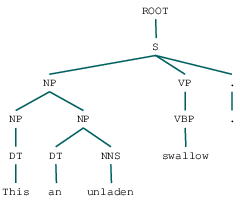

In [166]:
tree[0]

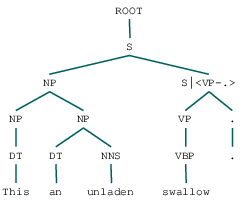

In [209]:
# dir(tree[0])
tree[0].chomsky_normal_form()
tree[0]

In [200]:
for (i,child) in enumerate(tree[0]): 
    print(i,child, child.flatten())

0 (S
  (NP (NP (DT This)) (NP (DT an) (NNS unladen)))
  (VP (VBP swallow))
  (. .)) (S This an unladen swallow .)


In [168]:
tree[0].productions()

[ROOT -> S,
 S -> NP VP .,
 NP -> NP NP,
 NP -> DT,
 DT -> 'This',
 NP -> DT NNS,
 DT -> 'an',
 NNS -> 'unladen',
 VP -> VBP,
 VBP -> 'swallow',
 . -> '.']

In [169]:
# [[(governor, dep, dependent) for governor, dep, dependent in parse.triples()] for parse in tree]

In [170]:
for t in tree[0]:
    print(t, t.treepositions())

(S
  (NP (NP (DT This)) (NP (DT an) (NNS unladen)))
  (VP (VBP swallow))
  (. .)) [(), (0,), (0, 0), (0, 0, 0), (0, 0, 0, 0), (0, 1), (0, 1, 0), (0, 1, 0, 0), (0, 1, 1), (0, 1, 1, 0), (1,), (1, 0), (1, 0, 0), (2,), (2, 0)]


In [171]:
tree[0].leaves()

['This', 'an', 'unladen', 'swallow', '.']

In [172]:
strees_list = list(tree[0].subtrees())

In [173]:
type(strees_list), len(strees_list)

(list, 11)

In [174]:
type(strees_list[0]), strees_list[5].leaves()

(nltk.tree.Tree, ['an', 'unladen'])

In [115]:
dir(st)

['__add__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__radd__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__rmul__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_frozen_class',
 '_get_node',
 '_label',
 '_parse_error',
 '_pformat_flat',
 '_repr_png_',
 '_set_node',
 'append',
 'chomsky_normal_form',
 'clear',
 'collapse_unary',
 'convert',
 'copy',
 'count',
 'draw',
 'extend',
 'flatten',
 'freeze',
 'fromstring',
 'height',
 'index',
 'insert',
 'label',
 'leaf_treeposition',
 'leaves',
 'node',
 'pformat',
 'pformat_latex_qtree',
 'pop',
 'pos',
 'pprint',
 'pretty_p

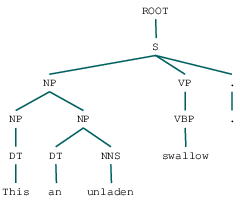

In [178]:
tree[0]

In [193]:
st_depth_list = []

for _, st in enumerate(strees_list):
    st_depth_list.append((len(st.treepositions()), st))
    print(st.height(), st.label(), st.leaves(), )
    ss = list(st.subtrees())
    for i in ss:
        print(i.height(), i.label(), i.leaves())
    break

6 ROOT ['This', 'an', 'unladen', 'swallow', '.']
6 ROOT ['This', 'an', 'unladen', 'swallow', '.']
5 S ['This', 'an', 'unladen', 'swallow', '.']
4 NP ['This', 'an', 'unladen']
3 NP ['This']
2 DT ['This']
3 NP ['an', 'unladen']
2 DT ['an']
2 NNS ['unladen']
3 VP ['swallow']
2 VBP ['swallow']
2 . ['.']


In [187]:
st.leaf_treeposition??

In [180]:
dir(st)

['__add__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__radd__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__rmul__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_frozen_class',
 '_get_node',
 '_label',
 '_parse_error',
 '_pformat_flat',
 '_repr_png_',
 '_set_node',
 'append',
 'chomsky_normal_form',
 'clear',
 'collapse_unary',
 'convert',
 'copy',
 'count',
 'draw',
 'extend',
 'flatten',
 'freeze',
 'fromstring',
 'height',
 'index',
 'insert',
 'label',
 'leaf_treeposition',
 'leaves',
 'node',
 'pformat',
 'pformat_latex_qtree',
 'pop',
 'pos',
 'pprint',
 'pretty_p

In [161]:
st.treepositions()

[(), (0,)]

In [156]:
for st in st_depth_list:
    print(st[0], st[1].label(), st[1].leaves())

27 ROOT ['What', 'is', 'the', 'airspeed', 'of', 'an', 'unladen', 'swallow', '?']
26 SBARQ ['What', 'is', 'the', 'airspeed', 'of', 'an', 'unladen', 'swallow', '?']
3 WHNP ['What']
2 WP ['What']
20 SQ ['is', 'the', 'airspeed', 'of', 'an', 'unladen', 'swallow']
2 VBZ ['is']
14 NP ['the', 'airspeed', 'of', 'an', 'unladen']
5 NP ['the', 'airspeed']
2 DT ['the']
2 NN ['airspeed']
8 PP ['of', 'an', 'unladen']
2 IN ['of']
5 NP ['an', 'unladen']
2 DT ['an']
2 JJ ['unladen']
3 S+VP ['swallow']
3 VP ['swallow']
2 VB ['swallow']
2 . ['?']


In [96]:
type(tree[0]), dir(tree[0])

(nltk.tree.Tree,
 ['__add__',
  '__class__',
  '__contains__',
  '__copy__',
  '__deepcopy__',
  '__delattr__',
  '__delitem__',
  '__dict__',
  '__dir__',
  '__doc__',
  '__eq__',
  '__format__',
  '__ge__',
  '__getattribute__',
  '__getitem__',
  '__gt__',
  '__hash__',
  '__iadd__',
  '__imul__',
  '__init__',
  '__init_subclass__',
  '__iter__',
  '__le__',
  '__len__',
  '__lt__',
  '__module__',
  '__mul__',
  '__ne__',
  '__new__',
  '__radd__',
  '__reduce__',
  '__reduce_ex__',
  '__repr__',
  '__reversed__',
  '__rmul__',
  '__setattr__',
  '__setitem__',
  '__sizeof__',
  '__str__',
  '__subclasshook__',
  '__weakref__',
  '_frozen_class',
  '_get_node',
  '_label',
  '_parse_error',
  '_pformat_flat',
  '_repr_png_',
  '_set_node',
  'append',
  'chomsky_normal_form',
  'clear',
  'collapse_unary',
  'convert',
  'copy',
  'count',
  'draw',
  'extend',
  'flatten',
  'freeze',
  'fromstring',
  'height',
  'index',
  'insert',
  'label',
  'leaf_treeposition',
  'leaves',

In [92]:
for st in tree:
    print(st)

(ROOT
  (SBARQ
    (WHNP (WP What))
    (SQ
      (VBZ is)
      (NP
        (NP (DT the) (NN airspeed))
        (PP (IN of) (NP (DT an) (JJ unladen))))
      (S (VP (VB swallow))))
    (. ?)))


In [91]:
type(tree), dir(tree)

(list,
 ['__add__',
  '__class__',
  '__contains__',
  '__delattr__',
  '__delitem__',
  '__dir__',
  '__doc__',
  '__eq__',
  '__format__',
  '__ge__',
  '__getattribute__',
  '__getitem__',
  '__gt__',
  '__hash__',
  '__iadd__',
  '__imul__',
  '__init__',
  '__init_subclass__',
  '__iter__',
  '__le__',
  '__len__',
  '__lt__',
  '__mul__',
  '__ne__',
  '__new__',
  '__reduce__',
  '__reduce_ex__',
  '__repr__',
  '__reversed__',
  '__rmul__',
  '__setattr__',
  '__setitem__',
  '__sizeof__',
  '__str__',
  '__subclasshook__',
  'append',
  'clear',
  'copy',
  'count',
  'extend',
  'index',
  'insert',
  'pop',
  'remove',
  'reverse',
  'sort'])

In [81]:
def get_chunks(sent):
    
    words = nltk.word_tokenize(sent)
    grammar = "NP:{<DT>?<JJ>*<NN>}"
    Reg_parser = nltk.RegexpParser(grammar)
    tree = Reg_parser.parse(nltk.pos_tag(words))
    
    strees = list(tree.subtrees())
    for i in strees:
        print(i.leaves())

In [82]:
get_chunks("This is only a test.")

[('This', 'DT'), ('is', 'VBZ'), ('only', 'RB'), ('a', 'DT'), ('test', 'NN'), ('.', '.')]
[('a', 'DT'), ('test', 'NN')]


In [58]:
def extract_chunks_using_parse_tree(conssentence, replace_with_dataset=True):
    
    conssentence = mask_entities(conssentence, replace_with_dataset)
    doc = nlp(conssentence)
    verb_subtree = []

    for s in doc.sents:
#         find_special_tokens = {"compar": [], "result": [], "method": [], "technique": [], "task": [], "dataset": [], "material": [], "metric": []}
        find_special_tokens = {"compar": [], "result": [], "method": [], "baseline": [], "task": [], 
                               "dataset": [],  "metric": [], "unfair": [], "fair": []}

        for tok in s:

            if tok.text.lower().startswith("compar"):
                find_special_tokens["compar"].append(tok)
            else:
                for k in sp_toks:
                    if tok.text.lower().startswith(k):
                        find_special_tokens[k].append(tok)
                        break

        verb_tokens = []
        if find_special_tokens["compar"]:
            for t in find_special_tokens["compar"]:
#                     verb_subtree.append(t.subtree)
                if t == s.root:
                    simplified_sent = ""
                    for chh in t.lefts:
                        simplified_sent = simplified_sent + " " + chh.text
                    simplified_sent = simplified_sent + " " + t.text
                    for chh in t.rights:
                        simplified_sent = simplified_sent + " " + chh.text
#                         print("SIMP: ", simplified_sent)
                    verb_subtree.append(simplified_sent)
                else:
                    verb_subtree.append(t.subtree)
        else:
            for k in sp_toks:
                for i in find_special_tokens[k]:
                    local_vt = []
                    for j in i.ancestors:
                        if j.pos_ == "NOUN":
                            local_vt.append(j)
                    if not local_vt:
                        for j in i.ancestors:
                            if j.pos_ == "VERB":
                                local_vt.append(j)
                    verb_tokens = verb_tokens + local_vt


            for i in verb_tokens:
                verb_subtree.append(i.subtree)

    eecc = []
    for i in verb_subtree:
        if type(i) == str:
            eecc.append(i)
        else:
            local_chunk = ""
            for lcaltok in i:
                local_chunk = local_chunk + " " + lcaltok.text
            eecc.append(local_chunk)
#     if not eecc:
#         print(conssentence)
    return list(set(eecc))


In [ ]:
"The experimental results are very good for document modeling, but without ablation analysis against the baseline it is hard to see why they should be with such a small modification in G-NVDM."

In [59]:
extract_chunks_using_spacy_dp("It would be interesting to explore the practicability of the method on more large-scale experiments on image related tasks.")

[' more large - scale experiments on image related tasks',
 ' the practicability of the method']

In [60]:
extract_chunks_using_spacy_dp("The experimental validation is also not extensive since comparison to SOTA is not included.")

[' comparison to SOTA']

In [61]:
roberta_vectors = defaultdict(dict)
skip_uids = []

for pid in gt_dict:
    roberta_vectors[pid] = {}
    
    for mcs in gt_dict[pid]["mcomp"]:
        try:
            mcomp_chunks_from_sent = extract_chunks_using_spacy_dp(df.loc[mcs]["Sent"])
            if mcomp_chunks_from_sent:
                final_chunk = ". ".join(mcomp_chunks_from_sent)
            else:
                final_chunk = df.loc[mcs]["Sent"]
            
            vec = embed_text_using_roberta(final_chunk.strip()).mean(1).detach().numpy()
            roberta_vectors[pid][mcs] = vec / norm(vec)
        except Exception as ex:
            print(pid, mcs, df.loc[mcs]["Sent"])
            skip_uids.append(mcs)
    
    for mcs in gt_dict[pid]["not_mcomp"]:
        try:
            mcomp_chunks_from_sent = extract_chunks_using_spacy_dp(df.loc[mcs]["Sent"])
            if mcomp_chunks_from_sent:
                final_chunk = ". ".join(mcomp_chunks_from_sent)
            else:
                final_chunk = df.loc[mcs]["Sent"]
            
            vec = embed_text_using_roberta(final_chunk.strip()).mean(1).detach().numpy()
            roberta_vectors[pid][mcs] = vec / norm(vec)
        except Exception as ex:
            print(pid, mcs, df.loc[mcs]["Sent"])
            skip_uids.append(mcs)
        

2019_HyVxPsC9tm 938 2
2019_HyVxPsC9tm 940 3
2020_Byg79h4tvB 1272 [1] Conditional adversarial domain adaptation, Long et.al, in NeurIPS 2018
[2] Towards Accurate Model Selection in Deep Unsupervised Domain Adaptation, You et.al, in ICML 2019
2018_HyHmGyZCZ 1425 2


In [62]:
mcomp_sentences = {}
not_mcomp_sentences = {}

for pid in gt_dict:
    for mcs in gt_dict[pid]["mcomp"]:
        if not mcs in skip_uids:
            mcomp_sentences[mcs] = pid
    for mcs in gt_dict[pid]["not_mcomp"]:
        if not mcs in skip_uids:
            not_mcomp_sentences[mcs] = pid
print(len(mcomp_sentences), len(not_mcomp_sentences))

117 1384


In [63]:
sim_with_mcomp = defaultdict(dict)
sim_with_not_mcomp = defaultdict(dict)
sim_with_notmcomp_paper_sents = defaultdict(dict)

mean_at_k = ["1", "3", "5", "7", "10", "20", "30", "50", "100", "500", "1000", "1380"]

for sid in mcomp_sentences:
    
    # 1. With other mcomp sentences
    temp_list = []    
    for osid in mcomp_sentences:
        if osid != sid:
            temp_list.append(np.inner(roberta_vectors[mcomp_sentences[osid]][osid], roberta_vectors[mcomp_sentences[sid]][sid])[0][0])
    
    sorted_temp_list = sorted(temp_list, reverse=True)
    sim_with_mcomp[sid]["mean"] = np.mean(sorted_temp_list)
    for vv in mean_at_k:
        sim_with_mcomp[sid]["mean_{}".format(vv)] = np.mean(sorted_temp_list[0:int(vv)])

    
    # 2. With other not_mcomp_sentences
    temp_list = []
    for osid in not_mcomp_sentences:
        temp_list.append(np.inner(roberta_vectors[not_mcomp_sentences[osid]][osid], roberta_vectors[mcomp_sentences[sid]][sid])[0][0])
    
    sorted_temp_list = sorted(temp_list, reverse=True)
    sim_with_not_mcomp[sid]["mean"] = np.mean(sorted_temp_list)
    for vv in mean_at_k:
        sim_with_not_mcomp[sid]["mean_{}".format(vv)] = np.mean(sorted_temp_list[0:int(vv)])

    
    # 3. With not_mcomp_sentences of the same paper
    temp_list = []    
    for osid in not_mcomp_sentences:
        if not_mcomp_sentences[osid] == mcomp_sentences[sid]:
            temp_list.append(np.inner(roberta_vectors[not_mcomp_sentences[osid]][osid], roberta_vectors[mcomp_sentences[sid]][sid])[0][0])
    
    sorted_temp_list = sorted(temp_list, reverse=True)
    sim_with_notmcomp_paper_sents[sid]["mean"] = np.mean(sorted_temp_list)
    for vv in mean_at_k:
        sim_with_notmcomp_paper_sents[sid]["mean_{}".format(vv)] = np.mean(sorted_temp_list[0:int(vv)])
    

In [64]:
# mean_sim_plot
diff12 = {"all": []}
for vv in mean_at_k:
    diff12[str(vv)] = []

diff13 = {"all": []}
for vv in mean_at_k:
    diff13[str(vv)] = []

for sid in sim_with_mcomp:
    diff12["all"].append(sim_with_mcomp[sid]["mean"] - sim_with_not_mcomp[sid]["mean"])
    diff13["all"].append(sim_with_mcomp[sid]["mean"] - sim_with_notmcomp_paper_sents[sid]["mean"])
    
    for vv in mean_at_k:
        diff12[str(vv)].append(sim_with_mcomp[sid]["mean_{}".format(vv)] - sim_with_not_mcomp[sid]["mean_{}".format(vv)])
        diff13[str(vv)].append(sim_with_mcomp[sid]["mean_{}".format(vv)] - sim_with_notmcomp_paper_sents[sid]["mean_{}".format(vv)])


# --------------------------------------------------------------------------------------------------------------

# 3. Analyse chunks after masking

In [96]:
masked_chunks = {"mcs": [], "nmcs": []}

for pid in gt_dict:
    for mcs in gt_dict[pid]["mcomp"]:
        try:
            mcomp_chunks_from_sent = extract_chunks_using_spacy_dp(df.loc[mcs]["Sent"])
            if mcomp_chunks_from_sent:
                final_chunk = ". ".join(mcomp_chunks_from_sent)
            else:
                final_chunk = df.loc[mcs]["Sent"]
            
            masked_chunks["mcs"].append((df.loc[mcs]["Sent"], final_chunk))
        except Exception as ex:
            continue
    
    for mcs in gt_dict[pid]["not_mcomp"]:
        try:
            mcomp_chunks_from_sent = extract_chunks_using_spacy_dp(df.loc[mcs]["Sent"])
            if mcomp_chunks_from_sent:
                final_chunk = ". ".join(mcomp_chunks_from_sent)
            else:
                final_chunk = df.loc[mcs]["Sent"]
            masked_chunks["nmcs"].append((df.loc[mcs]["Sent"], final_chunk))
        except Exception as ex:
            continue

In [97]:
extract_chunks_using_spacy_dp("The authors propose k-DPP as an open loop (oblivious to the evaluation of configurations) method for hyperparameter optimization and provide its empirical study and comparison with other methods such as grid search, uniform random search, low-discrepancy Sobol sequences, BO-TPE (Bayesian optimization using tree-structured Parzen estimator) by Bergstra et al (2011).")

[' comparison']

In [98]:
mask_entities("The authors propose k-DPP as an open loop (oblivious to the evaluation of configurations) method for hyperparameter optimization and provide its empirical study and comparison with other methods such as grid search, uniform random search, low-discrepancy Sobol sequences, BO-TPE (Bayesian optimization using tree-structured Parzen estimator) by Bergstra et al (2011).")

'The authors propose k-DPP as an open loop oblivious to the evaluation of configurations method for hyperparameter optimization and provide its empirical study and comparison with other methods such as grid search , uniform random search , low-discrepancy Sobol sequences , BO-TPE Bayesian optimization using tree-structured Parzen estimator by Bergstra et al 2011 .'

In [99]:
extract_chunks_using_spacy_dp("The authors propose k-DPP as an open loop (oblivious to the evaluation of configurations) method for hyperparameter optimization and provide its empirical study and comparison with other methods such as grid search, uniform random search, low-discrepancy Sobol sequences, BO-TPE (Bayesian optimization using tree-structured Parzen estimator) by Bergstra et al (2011).")

[' comparison']

In [100]:
extract_chunks_using_spacy_dp("The authors propose k-DPP as an open loop (oblivious to the evaluation of configurations) method for hyperparameter optimization and provide its empirical study and comparison with other methods such as grid search, uniform random search, low-discrepancy Sobol sequences, BO-TPE (Bayesian optimization using tree-structured Parzen estimator) by Bergstra et al (2011).")

[' comparison']

In [101]:
masked_chunks["mcs"][2:5]

[('The authors propose k-DPP as an open loop (oblivious to the evaluation of configurations) method for hyperparameter optimization and provide its empirical study and comparison with other methods such as grid search, uniform random search, low-discrepancy Sobol sequences, BO-TPE (Bayesian optimization using tree-structured Parzen estimator) by Bergstra et al (2011).',
  ' comparison'),
 ('Second, their study only applies to a small number like 3-6 hyperparameters with a small k=20) The real challenge lies in scaling up to many hyperparameters or even k-DPP sampling for larger k. Third, the authors do not compare against some relevant, recent work, e.g., Springenberg et al (http://aad.informatik.uni-freiburg.de/papers/16-NIPS-BOHamiANN.pdf) and Snoek et al (https://arxiv.org/pdf/1502.05700.pdf) that is essential for this kind of empirical study.',
  ' a small number like 3 - 6 metric with a small k 20.  lies , authors do not compare against'),
 ('COMMENTS ON THE CHANGES SINCE THE LAST

In [102]:
mask_entities("The authors propose k-DPP as an open loop (oblivious to the evaluation of configurations) method for hyperparameter optimization and provide its empirical study and comparison with other methods such as grid search, uniform random search, low-discrepancy Sobol sequences, BO-TPE (Bayesian optimization using tree-structured Parzen estimator) by Bergstra et al (2011).")

'The authors propose k-DPP as an open loop oblivious to the evaluation of configurations method for hyperparameter optimization and provide its empirical study and comparison with other methods such as grid search , uniform random search , low-discrepancy Sobol sequences , BO-TPE Bayesian optimization using tree-structured Parzen estimator by Bergstra et al 2011 .'

In [104]:
# The authors propose k-DPP as an open loop (oblivious to the evaluation of configurations) method for hyperparameter optimization and provide its empirical study and comparison with other methods such as grid search, uniform random search, low-discrepancy Sobol sequences, BO-TPE (Bayesian optimization using tree-structured Parzen estimator) by Bergstra et al (2011).

In [105]:
mask_entities("Third, the authors do not compare against some relevant, recent work, e.g., Springenberg et al (http://aad.informatik.uni-freiburg.de/papers/16-NIPS-BOHamiANN.pdf) and Snoek et al (https://arxiv.org/pdf/1502.05700.pdf) that is essential for this kind of empirical study.")

'Third , the authors do not compare against some relevant , recent work , e.g. , Springenberg et al http : aad.informatik.uni-freiburg.de papers 16-NIPS-BOHamiANN.pdf and Snoek et al https : arxiv.org pdf 1502.05700.pdf that is essential for this kind of empirical study .'

In [105]:
# def mask_entities(sentence, replace_with_dataset=False):
# #     cleaned_sent = re.sub('[^0-9a-zA-Z ]+', ' ', sentence)
#     cleaned_sent = sentence
#     while cleaned_sent.find("  ") > -1:
#         cleaned_sent = cleaned_sent.replace("  ", " ")
    
#     entities_found = []
#     for i in entity_key_map:
#         if cleaned_sent.find(" " + i + " ") > -1:
#             entities_found.append(i)
    
#     entities_found.sort(key=lambda s: len(s))
#     len_sorted_entities = entities_found.copy()
    
#     subset_entities = []
#     # Remove subset entities (eg: Among cnn and 3-layer-cnn, prefer the latter)
#     for fe in len_sorted_entities:
#         for other_ent in len_sorted_entities:
#             if fe != other_ent and other_ent.find(fe) > -1:
#                 subset_entities.append(fe)
#                 break
#     for se in subset_entities:
#         len_sorted_entities.remove(se)
#     for maxents in len_sorted_entities:
#         mask_name = entity_dict[entity_key_map[i]].lower()
#         if replace_with_dataset:
#             if mask_name == "material":
#                 mask_name = "dataset"
#         cleaned_sent = cleaned_sent.replace(maxents, mask_name)
#     words_cleaned = nltk.word_tokenize(cleaned_sent)
#     dups_removed = [v for i, v in enumerate(words_cleaned) if i == 0 or v != words_cleaned[i-1]]
#     new_dup_removed_sent = " ".join(dups_removed)
#     return new_dup_removed_sent.strip()

# #     #print(cleaned_sent)
# #     for i in entity_key_map:
# #         if cleaned_sent.find(" " + i + " ") > -1:
# #             #print("Substituting ent: {} with mask: {}".format(i, entity_dict[entity_key_map[i]].lower()))
# #             cleaned_sent = cleaned_sent.replace(i, entity_dict[entity_key_map[i]].lower())
# #     return cleaned_sent

### Analyse meaningful sentences that are more similar to NMCS in comparison to MCS.

In [106]:
ana_sim_with_mcomp = defaultdict(list)
ana_sim_with_not_mcomp = defaultdict(list)


mean_at_k = ["1", "3", "5", "7", "10", "20", "30", "50", "100", "500", "1000", "1380"]

for sid in mcomp_sentences:
    
    # 1. With other mcomp sentences
    temp_list = []    
    for osid in mcomp_sentences:
        if osid != sid:
            temp_list.append((osid, np.inner(roberta_vectors[mcomp_sentences[osid]][osid], roberta_vectors[mcomp_sentences[sid]][sid])[0][0]))
    
    sorted_temp_list = sorted(temp_list, key=lambda x: x[1], reverse=True)
    ana_sim_with_mcomp[sid] = sorted_temp_list

    
    # 2. With other not_mcomp_sentences
    temp_list = []
    for osid in not_mcomp_sentences:
        temp_list.append((osid, np.inner(roberta_vectors[not_mcomp_sentences[osid]][osid], roberta_vectors[mcomp_sentences[sid]][sid])[0][0]))
    
    sorted_temp_list = sorted(temp_list, key=lambda x: x[1], reverse=True)
    ana_sim_with_not_mcomp[sid] = sorted_temp_list

In [107]:
problematic_sentences_at_k = defaultdict(list)
unproblematic_sentences_at_k = defaultdict(list)
vv = 1

for sid in sim_with_mcomp:
    sim_diff = (sim_with_mcomp[sid]["mean_{}".format(vv)] - sim_with_not_mcomp[sid]["mean_{}".format(vv)])
    if sim_diff < 0:
        problematic_sentences_at_k[vv].append((sid,-1.0* sim_diff))
    else:
        unproblematic_sentences_at_k[vv].append((sid, sim_diff))

In [108]:
k = 1
sorted_problematic_sentences_at_1 = sorted(problematic_sentences_at_k[k], key=lambda x: x[1], reverse=True)
sorted(problematic_sentences_at_k[k], key=lambda x: x[1], reverse=True)[0:5]

[(113, 0.1638484001159668),
 (1464, 0.12271469831466675),
 (931, 0.1226879358291626),
 (950, 0.12097209692001343),
 (1318, 0.10917872190475464)]

In [109]:
# k = 1
# sorted_problematic_sentences_at_3 = sorted(problematic_sentences_at_k[3], key=lambda x: x[1], reverse=True)
# sorted(problematic_sentences_at_k[3], key=lambda x: x[1], reverse=True)[0:5]

In [110]:
# sorted_problematic_sentences_at_3[0:3], sorted_problematic_sentences_at_3[-3:]

In [111]:
# sorted_unproblematic_sentences_at_3 = sorted(unproblematic_sentences_at_k[3], key=lambda x: x[1], reverse=True)
# sorted_unproblematic_sentences_at_3[0:4], sorted_unproblematic_sentences_at_3[-4:]

In [113]:
for s in sorted_problematic_sentences_at_1[5:10]:
    print("Test sent: ", df.loc[s[0]]["Sent"])
    
    print("\nMeaningful comparison sentences: ")
    print(ana_sim_with_mcomp[s[0]][0:1])
    for i in ana_sim_with_mcomp[s[0]][0:1]:
        print(df.loc[i[0]]["Sent"])
    
    print("\nNon Meaningful comparison sentence: ")
    print(ana_sim_with_not_mcomp[s[0]][0:1])
    for i in ana_sim_with_not_mcomp[s[0]][0:1]:
        print(df.loc[i[0]]["Sent"])
    
    print("\n\n")

Test sent:  The experimental results are very good for document modeling, but without ablation analysis against the baseline it is hard to see why they should be with such a small modification in G-NVDM.

Meaningful comparison sentences: 
[(124, 0.74430156)]
What is left is the gated incremental pooling operation; but to show that this operation is beneficial when added to autoregressive CNNs, a thorough comparison with an autoregressive CNN baseline is necessary.

Non Meaningful comparison sentence: 
[(842, 0.8440055)]
Paper Weaknesses:
- The evaluation of the model is not great: (1) It would be interesting to combine bedroom and kitchen images and train jointly to see what it learns.



Test sent:  The paper does not consider the more recent and highly relevant Moosavi-Dezfooli et al “Universal Adversarial Perturbations” CVPR 2017.

Meaningful comparison sentences: 
[(1202, 0.5903547)]
- I am concerned about whether the proposed method works well with harder datasets such as Office-H

In [114]:
mask_entities("Minor comments:- I believe one should not compare the distance shown between the left and right columns of Figure 3 as they are obtained from two different models.")

'Minor comments : - I believe one should not compare the metric shown between the left and right columns of Figure 3 as they are obtained from two different models .'

In [115]:
extract_chunks_using_spacy_dp("Minor comments:- I believe one should not compare the distance shown between the left and right columns of Figure 3 as they are obtained from two different models.")

[' one should not compare the metric shown between the left and right columns of Figure 3 as they are obtained from two different models']

In [59]:
mask_entities("Although I do like the paper on the whole, to really convince me that main objective -- ie that **iterative** improvement is beneficial -- has been satifactorily demonstrated it would be necessary to include stronger baselines - and in particular, to show that an iterative refinement scheme can really improve over a system closely matched to the attention-based model, both when used in isolation and when used in system combination with a PBMT system, and to demonstrate that the PBMT system is not simply acting as a regulariser for the attention-based model.")

'Although I do like the paper on the whole , to really convince me that main objective -- ie that iterative improvement is beneficial -- has been satifactorily demonstrated it would be necessary to include stronger baselines - and in particular , to show that an metric scheme can really improve over a system closely matched to the attention-based model , both when used in isolation and when used in system combination with a PBMT system , and to demonstrate that the PBMT system is not simply acting as a regulariser for the attention-based model .'

In [58]:
extract_chunks_using_spacy_dp("Although I do like the paper on the whole, to really convince me that main objective -- ie that **iterative** improvement is beneficial -- has been satifactorily demonstrated it would be necessary to include stronger baselines - and in particular, to show that an iterative refinement scheme can really improve over a system closely matched to the attention-based model, both when used in isolation and when used in system combination with a PBMT system, and to demonstrate that the PBMT system is not simply acting as a regulariser for the attention-based model.")

[' an metric scheme']

In [56]:
mask_entities("In summary, while I think the paper is interesting, I suspect that the applicability of this technique is possibly limited at present, and I'm unsure how much we can really read into the findings of the paper when the experiments are based on MNIST alone.")

'In summary , while I think the paper is interesting , I suspect that the applicability of this technique is possibly limited at present , and I m unsure how much we can really read into the findings of the paper when the experiments are based on MNIST alone .'

In [84]:
extract_chunks_using_spacy_dp("However, it's not completely fair to compare a label-noise + semi-supervised method with other label-noise only methods... As a matter of fact, you don't need to apply perturbation consistency (or other semi-supervised) regularization after identifying the training data with incorrect labels.")

[' to compare a label - noise semi - supervised method with other label - noise only methods',
 ' perturbation consistency or other semi - supervised metric']